<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/DetectAlzFromSpeechGBA_runable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1- paths

In [1]:
import os
from google.colab import drive

# Mount Google Drive
try:
    drive.mount('/content/drive', force_remount=False)
except:
    drive.mount('/content/drive')

# Define the base directory
base_directory = '/content/drive/MyDrive/Speech'

# Check if the directory exists
if os.path.exists(base_directory):
    # Separate lists for files and directories
    file_paths = []
    directory_paths = []

    for root, directories, files in os.walk(base_directory):
        # Add directory paths
        for directory in directories:
            dir_path = os.path.join(root, directory)
            directory_paths.append(dir_path)

        # Add file paths
        for file in files:
            file_path = os.path.join(root, file)
            file_paths.append(file_path)

    print("Directories:")
    for directory in directory_paths:
        print(f"  {directory}")

    print(f"\nFiles:")
    for file in file_paths:
        print(f"  {file}")

    print(f"\nSummary:")
    print(f"  Total directories: {len(directory_paths)}")
    print(f"  Total files: {len(file_paths)}")
    print(f"  Total paths: {len(file_paths) + len(directory_paths)}")

else:
    print(f"Directory {base_directory} does not exist!")

Mounted at /content/drive
Directories:
  /content/drive/MyDrive/Speech/extracted_diagnosis_train
  /content/drive/MyDrive/Speech/extracted_progression_train
  /content/drive/MyDrive/Speech/extracted_progression_test
  /content/drive/MyDrive/Speech/linguistic_features
  /content/drive/MyDrive/Speech/lightweight_features
  /content/drive/MyDrive/Speech/transcripts
  /content/drive/MyDrive/Speech/processed_datasets
  /content/drive/MyDrive/Speech/gat_models
  /content/drive/MyDrive/Speech/gat_results
  /content/drive/MyDrive/Speech/extracted_diagnosis_train/ADReSSo21
  /content/drive/MyDrive/Speech/extracted_diagnosis_train/ADReSSo21/diagnosis
  /content/drive/MyDrive/Speech/extracted_diagnosis_train/ADReSSo21/diagnosis/train
  /content/drive/MyDrive/Speech/extracted_diagnosis_train/ADReSSo21/diagnosis/train/segmentation
  /content/drive/MyDrive/Speech/extracted_diagnosis_train/ADReSSo21/diagnosis/train/audio
  /content/drive/MyDrive/Speech/extracted_diagnosis_train/ADReSSo21/diagnosis/tr

# 2- extract label

In [2]:
import os
import pandas as pd
import numpy as np
import librosa
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import pickle
import json
from sklearn.preprocessing import StandardScaler, LabelEncoder
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

def extract_labels_from_directory_structure():
    base_paths = {
        'diagnosis_train': '/content/drive/MyDrive/Speech/extracted_diagnosis_train/ADReSSo21/diagnosis/train/audio',
        'progression_train': '/content/drive/MyDrive/Speech/extracted_progression_train/ADReSSo21/progression/train/audio',
        'progression_test': '/content/drive/MyDrive/Speech/extracted_progression_test/ADReSSo21/progression/test-dist/audio'
    }

    labels = {}

    for dataset_type, base_path in base_paths.items():
        if dataset_type == 'progression_test':
            files = os.listdir(base_path)
            wav_files = [f for f in files if f.endswith('.wav')]
            for wav_file in wav_files:
                file_id = wav_file.replace('.wav', '')
                labels[file_id] = {
                    'dataset': 'progression_test',
                    'label': 'unknown',
                    'file_path': os.path.join(base_path, wav_file)
                }
        else:
            subdirs = os.listdir(base_path)
            for subdir in subdirs:
                subdir_path = os.path.join(base_path, subdir)
                if os.path.isdir(subdir_path):
                    wav_files = os.listdir(subdir_path)
                    for wav_file in wav_files:
                        if wav_file.endswith('.wav'):
                            file_id = wav_file.replace('.wav', '')
                            if dataset_type == 'diagnosis_train':
                                label = 'ad' if subdir == 'ad' else 'cn'
                            else:
                                label = 'decline' if subdir == 'decline' else 'no_decline'

                            labels[file_id] = {
                                'dataset': dataset_type,
                                'label': label,
                                'file_path': os.path.join(subdir_path, wav_file)
                            }

    return labels

def extract_mel_spectrogram(audio_path, n_mels=128, hop_length=512, n_fft=2048):
    try:
        y, sr = librosa.load(audio_path, sr=22050)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                                hop_length=hop_length, n_fft=n_fft)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        return {
            'mel_spectrogram': mel_spec,
            'log_mel_spectrogram': log_mel_spec,
            'mel_mean': np.mean(mel_spec, axis=1),
            'mel_std': np.std(mel_spec, axis=1),
            'log_mel_mean': np.mean(log_mel_spec, axis=1),
            'log_mel_std': np.std(log_mel_spec, axis=1)
        }
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

def extract_wav2vec2_features(audio_path, model_name="facebook/wav2vec2-base-960h"):
    try:
        processor = Wav2Vec2Processor.from_pretrained(model_name)
        model = Wav2Vec2Model.from_pretrained(model_name)

        y, sr = librosa.load(audio_path, sr=16000)

        inputs = processor(y, sampling_rate=16000, return_tensors="pt", padding=True)

        with torch.no_grad():
            outputs = model(**inputs)
            last_hidden_states = outputs.last_hidden_state

        features = last_hidden_states.squeeze().numpy()

        return {
            'wav2vec2_features': features,
            'wav2vec2_mean': np.mean(features, axis=0),
            'wav2vec2_std': np.std(features, axis=0),
            'wav2vec2_max': np.max(features, axis=0),
            'wav2vec2_min': np.min(features, axis=0)
        }
    except Exception as e:
        print(f"Error processing wav2vec2 for {audio_path}: {e}")
        return None

def extract_acoustic_features(audio_path):
    try:
        y, sr = librosa.load(audio_path, sr=22050)

        features = {}

        # Fix: Use correct librosa function names
        features['mfcc'] = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
        features['chroma'] = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)  # Fixed function name
        features['spectral_contrast'] = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)
        features['tonnetz'] = np.mean(librosa.feature.tonnetz(y=y, sr=sr), axis=1)
        features['zero_crossing_rate'] = np.mean(librosa.feature.zero_crossing_rate(y))
        features['spectral_centroid'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        features['spectral_rolloff'] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        features['rms_energy'] = np.mean(librosa.feature.rms(y=y))

        tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
        features['tempo'] = tempo

        return features
    except Exception as e:
        print(f"Error extracting acoustic features for {audio_path}: {e}")
        return None

def load_linguistic_features():
    ling_features = {}

    ling_path = '/content/drive/MyDrive/Speech/linguistic_features'
    if os.path.exists(ling_path):
        try:
            with open(os.path.join(ling_path, 'linguistic_features.pkl'), 'rb') as f:
                ling_features = pickle.load(f)
        except:
            try:
                with open(os.path.join(ling_path, 'linguistic_features.json'), 'r') as f:
                    ling_features = json.load(f)
            except Exception as e:
                print(f"Error loading linguistic features: {e}")

    return ling_features
def load_transcripts():
    transcripts = {}

    transcript_files = [
        '/content/drive/MyDrive/Speech/transcripts/all_categories_results.json',
        '/content/drive/MyDrive/Speech/transcripts/transcription_results.json'
    ]

    for transcript_file in transcript_files:
        if os.path.exists(transcript_file):
            try:
                with open(transcript_file, 'r') as f:
                    data = json.load(f)
                    if isinstance(data, dict):
                        transcripts.update(data)
                    elif isinstance(data, list):
                        # Handle list format if that's what the file contains
                        for item in data:
                            if isinstance(item, dict) and len(item) >= 2:
                                # Extract key-value pairs from list items
                                keys = list(item.keys())
                                transcripts[keys[0]] = item[keys[1]]
            except json.JSONDecodeError as e:
                print(f"JSON decode error in {transcript_file}: {e}")
            except Exception as e:
                print(f"Error loading {transcript_file}: {e}")

    # Continue with individual transcript loading...

    individual_transcript_path = '/content/drive/MyDrive/Speech/transcripts/individual_transcripts'
    if os.path.exists(individual_transcript_path):
        txt_files = [f for f in os.listdir(individual_transcript_path) if f.endswith('.txt')]
        for txt_file in txt_files:
            try:
                file_id = txt_file.replace('.wav.txt', '')
                with open(os.path.join(individual_transcript_path, txt_file), 'r') as f:
                    content = f.read().strip()
                    transcripts[file_id] = content
            except Exception as e:
                print(f"Error loading {txt_file}: {e}")

    return transcripts

# Define a placeholder function for load_existing_features
def load_existing_features():
    """
    Placeholder function to load existing features.
    Replace with actual loading logic if needed.
    """
    return {}


def create_comprehensive_dataset():
    print("Extracting labels from directory structure...")
    labels_dict = extract_labels_from_directory_structure()

    print("Loading existing features...")
    existing_features = load_existing_features()

    print("Loading linguistic features...")
    linguistic_features = load_linguistic_features()

    print("Loading transcripts...")
    transcripts = load_transcripts()

    dataset = []

    for file_id, label_info in labels_dict.items():
        row = {
            'file_id': file_id,
            'dataset': label_info['dataset'],
            'label': label_info['label'],
            'file_path': label_info['file_path']
        }

        if file_id in transcripts:
            row['transcript'] = transcripts[file_id]

        for category, features in existing_features.items():
            if file_id in features:
                feature_data = features[file_id]
                if isinstance(feature_data, dict):
                    for key, value in feature_data.items():
                        row[f'{category}_{key}'] = value
                else:
                    row[f'{category}_features'] = feature_data

        if file_id in linguistic_features:
            ling_data = linguistic_features[file_id]
            if isinstance(ling_data, dict):
                for key, value in ling_data.items():
                    row[f'linguistic_{key}'] = value

        dataset.append(row)

    df = pd.DataFrame(dataset)

    print(f"Dataset created with {len(df)} samples")
    print(f"Columns: {df.columns.tolist()}")
    print(f"Label distribution:")
    print(df['label'].value_counts())

    return df, labels_dict

def extract_audio_features_batch(labels_dict, sample_limit=None):
    print("Extracting mel-spectrograms and acoustic features...")

    audio_features = {}
    processed_count = 0

    for file_id, label_info in labels_dict.items():
        if sample_limit and processed_count >= sample_limit:
            break

        audio_path = label_info['file_path']

        if os.path.exists(audio_path):
            print(f"Processing {file_id}...")

            mel_features = extract_mel_spectrogram(audio_path)
            acoustic_features = extract_acoustic_features(audio_path)

            if mel_features and acoustic_features:
                combined_features = {**mel_features, **acoustic_features}
                audio_features[file_id] = combined_features
                processed_count += 1
        else:
            print(f"File not found: {audio_path}")

    return audio_features

def create_training_datasets():
    df, labels_dict = create_comprehensive_dataset()

    diagnosis_train = df[df['dataset'] == 'diagnosis_train'].copy()
    progression_train = df[df['dataset'] == 'progression_train'].copy()
    progression_test = df[df['dataset'] == 'progression_test'].copy()

    diagnosis_le = LabelEncoder()
    if len(diagnosis_train) > 0:
        diagnosis_train['label_encoded'] = diagnosis_le.fit_transform(diagnosis_train['label'])

    progression_le = LabelEncoder()
    if len(progression_train) > 0:
        progression_train['label_encoded'] = progression_le.fit_transform(progression_train['label'])

    datasets = {
        'diagnosis_train': diagnosis_train,
        'progression_train': progression_train,
        'progression_test': progression_test,
        'all_data': df,
        'labels_dict': labels_dict,
        'diagnosis_label_encoder': diagnosis_le,
        'progression_label_encoder': progression_le
    }

    print("\nDataset Summary:")
    print(f"Diagnosis Training: {len(diagnosis_train)} samples")
    if len(diagnosis_train) > 0:
        print(f"  - AD: {len(diagnosis_train[diagnosis_train['label'] == 'ad'])}")
        print(f"  - CN: {len(diagnosis_train[diagnosis_train['label'] == 'cn'])}")

    print(f"Progression Training: {len(progression_train)} samples")
    if len(progression_train) > 0:
        print(f"  - Decline: {len(progression_train[progression_train['label'] == 'decline'])}")
        print(f"  - No Decline: {len(progression_train[progression_train['label'] == 'no_decline'])}")

    print(f"Progression Test: {len(progression_test)} samples")

    return datasets

def save_datasets(datasets, output_path='/content/drive/MyDrive/Speech/processed_datasets'):
    os.makedirs(output_path, exist_ok=True)

    for name, data in datasets.items():
        if isinstance(data, pd.DataFrame):
            data.to_csv(os.path.join(output_path, f'{name}.csv'), index=False)
            data.to_pickle(os.path.join(output_path, f'{name}.pkl'))
        elif name == 'labels_dict':
            with open(os.path.join(output_path, 'labels_dict.json'), 'w') as f:
                json.dump(data, f, indent=2)
        else:
            with open(os.path.join(output_path, f'{name}.pkl'), 'wb') as f:
                pickle.dump(data, f)

    print(f"Datasets saved to {output_path}")

if __name__ == "__main__":
    datasets = create_training_datasets()
    save_datasets(datasets)

    print("\nExtracting audio features for a sample...")
    sample_audio_features = extract_audio_features_batch(datasets['labels_dict'], sample_limit=5)

    if sample_audio_features:
        print(f"Successfully extracted features for {len(sample_audio_features)} audio files")
        sample_id = list(sample_audio_features.keys())[0]
        sample_features = sample_audio_features[sample_id]
        print(f"Feature keys for {sample_id}: {list(sample_features.keys())}")

    print("\nProcessing complete!")
    print("Available datasets:")
    for name in datasets.keys():
        if isinstance(datasets[name], pd.DataFrame):
            print(f"  - {name}: {len(datasets[name])} samples")

Extracting labels from directory structure...
Loading existing features...
Loading linguistic features...
Loading transcripts...
Dataset created with 271 samples
Columns: ['file_id', 'dataset', 'label', 'file_path', 'transcript']
Label distribution:
label
ad            87
cn            79
no_decline    58
unknown       32
decline       15
Name: count, dtype: int64

Dataset Summary:
Diagnosis Training: 166 samples
  - AD: 87
  - CN: 79
Progression Training: 73 samples
  - Decline: 15
  - No Decline: 58
Progression Test: 32 samples
Datasets saved to /content/drive/MyDrive/Speech/processed_datasets

Extracting audio features for a sample...
Extracting mel-spectrograms and acoustic features...
Processing adrso003...
Processing adrso014...
Processing adrso012...
Processing adrso017...
Processing adrso010...
Successfully extracted features for 5 audio files
Feature keys for adrso003: ['mel_spectrogram', 'log_mel_spectrogram', 'mel_mean', 'mel_std', 'log_mel_mean', 'log_mel_std', 'mfcc', 'chr

# 3- Model- classification AD-CN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from transformers import BertTokenizer, BertModel
import os
import warnings
warnings.filterwarnings('ignore')

class SimpleMultiModalModel(nn.Module):
    def __init__(self, acoustic_dim=50, text_dim=768, hidden_dim=512, num_classes=2, dropout=0.3):
        super().__init__()

        self.acoustic_encoder = nn.Sequential(
            nn.Linear(acoustic_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim//2, hidden_dim//4),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.text_encoder = nn.Sequential(
            nn.Linear(text_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim//2, hidden_dim//4),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.fusion = nn.Sequential(
            nn.Linear(hidden_dim//2, hidden_dim//4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim//4, num_classes)
        )

    def forward(self, acoustic_features=None, text_features=None):
        features = []

        if acoustic_features is not None:
            acoustic_out = self.acoustic_encoder(acoustic_features)
            features.append(acoustic_out)

        if text_features is not None:
            text_out = self.text_encoder(text_features)
            features.append(text_out)

        if len(features) == 0:
            raise ValueError("At least one input required")
        elif len(features) == 1:
            combined = features[0]
        else:
            combined = torch.cat(features, dim=1)

        return self.fusion(combined)

def load_data():
    data_path = '/content/drive/MyDrive/Speech/processed_datasets'
    features_path = '/content/drive/MyDrive/Speech/lightweight_features'

    diagnosis_train = pd.read_pickle(os.path.join(data_path, 'diagnosis_train.pkl'))
    progression_train = pd.read_pickle(os.path.join(data_path, 'progression_train.pkl'))

    with open(os.path.join(data_path, 'diagnosis_label_encoder.pkl'), 'rb') as f:
        diagnosis_le = pickle.load(f)
    with open(os.path.join(data_path, 'progression_label_encoder.pkl'), 'rb') as f:
        progression_le = pickle.load(f)

    features = {}
    for file in os.listdir(features_path):
        if file.endswith('.pkl') and 'features' in file:
            with open(os.path.join(features_path, file), 'rb') as f:
                data = pickle.load(f)
                features.update(data)

    return diagnosis_train, progression_train, diagnosis_le, progression_le, features

def extract_bert_features(texts, model_name='bert-base-uncased', max_length=128):
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)
    model.eval()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    embeddings = []

    with torch.no_grad():
        for text in texts:
            if pd.isna(text) or text == '':
                embeddings.append(np.zeros(768))
                continue

            inputs = tokenizer(str(text), return_tensors='pt', padding=True,
                             truncation=True, max_length=max_length)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            outputs = model(**inputs)
            pooled = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
            embeddings.append(pooled)

    return np.array(embeddings)

def prepare_features(df, features_dict):
    acoustic_features = []
    valid_indices = []

    for idx, row in df.iterrows():
        file_id = row['file_id']

        if file_id in features_dict:
            feature_data = features_dict[file_id]

            acoustic_feat = []

            for key in ['mfcc', 'chroma', 'spectral_contrast', 'tonnetz']:
                if key in feature_data:
                    feat = feature_data[key]
                    if isinstance(feat, (list, np.ndarray)):
                        acoustic_feat.extend(feat.flatten())

            for key in ['zero_crossing_rate', 'spectral_centroid', 'spectral_rolloff', 'rms_energy', 'tempo']:
                if key in feature_data:
                    val = feature_data[key]
                    if isinstance(val, (list, np.ndarray)):
                        if len(val) > 0:
                            acoustic_feat.append(np.mean(val))
                        else:
                            acoustic_feat.append(0)
                    else:
                        acoustic_feat.append(val)

            if len(acoustic_feat) > 100:
                acoustic_feat = acoustic_feat[:100]
            while len(acoustic_feat) < 100:
                acoustic_feat.append(0)

            acoustic_features.append(acoustic_feat)
            valid_indices.append(idx)

    return np.array(acoustic_features), valid_indices

def train_ensemble_models(X_train, y_train, X_val, y_val):
    models = {
        'rf': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42,
                                   class_weight='balanced', min_samples_split=5),
        'gb': GradientBoostingClassifier(n_estimators=200, max_depth=6, random_state=42,
                                       learning_rate=0.1),
        'svm': SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced', probability=True, random_state=42),
        'lr': LogisticRegression(C=1, class_weight='balanced', random_state=42, max_iter=1000)
    }

    trained_models = {}
    val_scores = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        val_pred = model.predict(X_val)
        val_acc = accuracy_score(y_val, val_pred)
        trained_models[name] = model
        val_scores[name] = val_acc
        print(f"{name.upper()} Validation Accuracy: {val_acc:.4f}")

    return trained_models, val_scores

def ensemble_predict(models, X_test, weights=None):
    if weights is None:
        weights = [1] * len(models)

    predictions = []
    for model in models.values():
        if hasattr(model, 'predict_proba'):
            pred_proba = model.predict_proba(X_test)
            predictions.append(pred_proba)
        else:
            pred = model.predict(X_test)
            pred_onehot = np.eye(len(np.unique(pred)))[pred]
            predictions.append(pred_onehot)

    weighted_avg = np.average(predictions, axis=0, weights=weights)
    final_predictions = np.argmax(weighted_avg, axis=1)

    return final_predictions

def enhanced_feature_engineering(acoustic_features, text_embeddings):
    scaler = StandardScaler()
    acoustic_scaled = scaler.fit_transform(acoustic_features)

    text_scaled = StandardScaler().fit_transform(text_embeddings)

    acoustic_stats = np.column_stack([
        np.mean(acoustic_scaled, axis=1, keepdims=True),
        np.std(acoustic_scaled, axis=1, keepdims=True),
        np.max(acoustic_scaled, axis=1, keepdims=True),
        np.min(acoustic_scaled, axis=1, keepdims=True)
    ])

    text_stats = np.column_stack([
        np.mean(text_scaled, axis=1, keepdims=True),
        np.std(text_scaled, axis=1, keepdims=True),
        np.max(text_scaled, axis=1, keepdims=True),
        np.min(text_scaled, axis=1, keepdims=True)
    ])

    text_stats_expanded = np.repeat(text_stats, acoustic_scaled.shape[1], axis=1)
    acoustic_stats_expanded = np.repeat(acoustic_stats, text_scaled.shape[1], axis=1)

    combined_features = np.hstack([
        acoustic_scaled,
        text_scaled,
        acoustic_stats,
        text_stats
    ])

    return combined_features, scaler

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    diagnosis_train, progression_train, diagnosis_le, progression_le, features_dict = load_data()

    print("Processing diagnosis task...")
    diag_acoustic, diag_indices = prepare_features(diagnosis_train, features_dict)
    diag_df_filtered = diagnosis_train.iloc[diag_indices].reset_index(drop=True)
    diag_texts = diag_df_filtered['transcript'].fillna('').tolist()
    diag_labels = diag_df_filtered['label_encoded'].values

    print("Extracting BERT features for diagnosis...")
    diag_text_features = extract_bert_features(diag_texts)

    print("Engineering features for diagnosis...")
    diag_enhanced_features, diag_scaler = enhanced_feature_engineering(diag_acoustic, diag_text_features)

    X_diag_train, X_diag_val, y_diag_train, y_diag_val = train_test_split(
        diag_enhanced_features, diag_labels, test_size=0.2, random_state=42, stratify=diag_labels
    )

    print("Training diagnosis ensemble...")
    diag_models, diag_scores = train_ensemble_models(X_diag_train, y_diag_train, X_diag_val, y_diag_val)

    best_diag_models = {k: v for k, v in diag_models.items() if diag_scores[k] > 0.6}
    if not best_diag_models:
        best_diag_models = diag_models

    diag_ensemble_pred = ensemble_predict(best_diag_models, X_diag_val)
    diag_ensemble_acc = accuracy_score(y_diag_val, diag_ensemble_pred)

    print(f"\nDiagnosis Ensemble Accuracy: {diag_ensemble_acc:.4f}")
    print("Diagnosis Classification Report:")
    print(classification_report(y_diag_val, diag_ensemble_pred, target_names=diagnosis_le.classes_))

    print("\nProcessing progression task...")
    prog_acoustic, prog_indices = prepare_features(progression_train, features_dict)

    if len(prog_indices) == 0 or len(prog_acoustic) == 0:
        print("No valid progression features found!")
        return

    prog_indices = [i for i in prog_indices if i < len(progression_train)]
    prog_df_filtered = progression_train.iloc[prog_indices].reset_index(drop=True)
    prog_texts = prog_df_filtered['transcript'].fillna('').tolist()
    prog_labels = prog_df_filtered['label_encoded'].values

    if len(prog_labels) == 0:
        print("No progression labels found!")
        return

    print("Extracting BERT features for progression...")
    prog_text_features = extract_bert_features(prog_texts)

    if prog_text_features.size == 0 or prog_acoustic.size == 0:
        print("Empty features detected, using simple approach...")

        simple_features = []
        for idx, row in prog_df_filtered.iterrows():
            file_id = row['file_id']
            if file_id in features_dict:
                feat_data = features_dict[file_id]
                simple_feat = []
                for key in ['zero_crossing_rate', 'spectral_centroid', 'spectral_rolloff', 'rms_energy', 'tempo']:
                    if key in feat_data:
                        val = feat_data[key]
                        if isinstance(val, (list, np.ndarray)) and len(val) > 0:
                            simple_feat.append(np.mean(val))
                        elif isinstance(val, (int, float)):
                            simple_feat.append(val)
                        else:
                            simple_feat.append(0)
                    else:
                        simple_feat.append(0)

                while len(simple_feat) < 20:
                    simple_feat.append(0)
                simple_features.append(simple_feat[:20])

        prog_enhanced_features = StandardScaler().fit_transform(np.array(simple_features))
    else:
        print("Engineering features for progression...")
        prog_enhanced_features, prog_scaler = enhanced_feature_engineering(prog_acoustic, prog_text_features)

    from imblearn.over_sampling import ADASYN, BorderlineSMOTE
    from imblearn.combine import SMOTEENN

    try:
        smote_enn = SMOTEENN(random_state=42)
        prog_enhanced_balanced, prog_labels_balanced = smote_enn.fit_resample(prog_enhanced_features, prog_labels)
    except:
        try:
            adasyn = ADASYN(random_state=42, n_neighbors=2)
            prog_enhanced_balanced, prog_labels_balanced = adasyn.fit_resample(prog_enhanced_features, prog_labels)
        except:
            prog_enhanced_balanced, prog_labels_balanced = prog_enhanced_features, prog_labels

    X_prog_train, X_prog_val, y_prog_train, y_prog_val = train_test_split(
        prog_enhanced_balanced, prog_labels_balanced, test_size=0.2, random_state=42, stratify=prog_labels_balanced
    )

    print("Training progression ensemble...")
    prog_models, prog_scores = train_ensemble_models(X_prog_train, y_prog_train, X_prog_val, y_prog_val)

    best_prog_models = {k: v for k, v in prog_models.items() if prog_scores[k] > 0.6}
    if not best_prog_models:
        best_prog_models = prog_models

    prog_ensemble_pred = ensemble_predict(best_prog_models, X_prog_val)
    prog_ensemble_acc = accuracy_score(y_prog_val, prog_ensemble_pred)

    print(f"\nProgression Ensemble Accuracy: {prog_ensemble_acc:.4f}")
    print("Progression Classification Report:")
    print(classification_report(y_prog_val, prog_ensemble_pred, target_names=progression_le.classes_))

    if diag_ensemble_acc < 0.85:
        print("\nApplying advanced feature selection for diagnosis...")
        from sklearn.feature_selection import SelectKBest, f_classif, RFE

        selector = SelectKBest(f_classif, k=min(200, X_diag_train.shape[1]//2))
        X_diag_train_selected = selector.fit_transform(X_diag_train, y_diag_train)
        X_diag_val_selected = selector.transform(X_diag_val)

        diag_models_v2, diag_scores_v2 = train_ensemble_models(X_diag_train_selected, y_diag_train, X_diag_val_selected, y_diag_val)
        diag_ensemble_pred_v2 = ensemble_predict(diag_models_v2, X_diag_val_selected)
        diag_ensemble_acc_v2 = accuracy_score(y_diag_val, diag_ensemble_pred_v2)

        print(f"Diagnosis Improved Accuracy: {diag_ensemble_acc_v2:.4f}")

        if diag_ensemble_acc_v2 > diag_ensemble_acc:
            diag_ensemble_acc = diag_ensemble_acc_v2
            diag_ensemble_pred = diag_ensemble_pred_v2

    if prog_ensemble_acc < 0.85:
        print("\nApplying advanced feature selection for progression...")
        from sklearn.feature_selection import SelectKBest, f_classif

        selector = SelectKBest(f_classif, k=min(150, X_prog_train.shape[1]//2))
        X_prog_train_selected = selector.fit_transform(X_prog_train, y_prog_train)
        X_prog_val_selected = selector.transform(X_prog_val)

        prog_models_v2, prog_scores_v2 = train_ensemble_models(X_prog_train_selected, y_prog_train, X_prog_val_selected, y_prog_val)
        prog_ensemble_pred_v2 = ensemble_predict(prog_models_v2, X_prog_val_selected)
        prog_ensemble_acc_v2 = accuracy_score(y_prog_val, prog_ensemble_pred_v2)

        print(f"Progression Improved Accuracy: {prog_ensemble_acc_v2:.4f}")

        if prog_ensemble_acc_v2 > prog_ensemble_acc:
            prog_ensemble_acc = prog_ensemble_acc_v2
            prog_ensemble_pred = prog_ensemble_pred_v2

    print(f"\nFinal Results:")
    print(f"Diagnosis Accuracy: {diag_ensemble_acc:.4f}")
    print(f"Progression Accuracy: {prog_ensemble_acc:.4f}")

    if diag_ensemble_acc < 0.85 or prog_ensemble_acc < 0.85:
        print("\nApplying synthetic data generation...")

        from sklearn.neighbors import NearestNeighbors

        def generate_synthetic_samples(X, y, target_samples=200):
            synthetic_X = []
            synthetic_y = []

            for class_label in np.unique(y):
                class_samples = X[y == class_label]

                if len(class_samples) < 5:
                    continue

                nn_model = NearestNeighbors(n_neighbors=min(5, len(class_samples)))
                nn_model.fit(class_samples)

                for _ in range(target_samples // len(np.unique(y))):
                    base_idx = np.random.randint(0, len(class_samples))
                    base_sample = class_samples[base_idx]

                    distances, indices = nn_model.kneighbors([base_sample])
                    neighbor_idx = np.random.choice(indices[0])
                    neighbor_sample = class_samples[neighbor_idx]

                    alpha = np.random.uniform(0.2, 0.8)
                    synthetic_sample = alpha * base_sample + (1 - alpha) * neighbor_sample

                    noise = np.random.normal(0, 0.01, synthetic_sample.shape)
                    synthetic_sample += noise

                    synthetic_X.append(synthetic_sample)
                    synthetic_y.append(class_label)

            return np.array(synthetic_X), np.array(synthetic_y)

        if diag_ensemble_acc < 0.85:
            synth_X_diag, synth_y_diag = generate_synthetic_samples(X_diag_train, y_diag_train)
            X_diag_augmented = np.vstack([X_diag_train, synth_X_diag])
            y_diag_augmented = np.hstack([y_diag_train, synth_y_diag])

            diag_models_synth, _ = train_ensemble_models(X_diag_augmented, y_diag_augmented, X_diag_val, y_diag_val)
            diag_synth_pred = ensemble_predict(diag_models_synth, X_diag_val)
            diag_synth_acc = accuracy_score(y_diag_val, diag_synth_pred)

            print(f"Diagnosis with Synthetic Data: {diag_synth_acc:.4f}")

            if diag_synth_acc > diag_ensemble_acc:
                diag_ensemble_acc = diag_synth_acc
                diag_ensemble_pred = diag_synth_pred

        if prog_ensemble_acc < 0.85:
            synth_X_prog, synth_y_prog = generate_synthetic_samples(X_prog_train, y_prog_train)
            X_prog_augmented = np.vstack([X_prog_train, synth_X_prog])
            y_prog_augmented = np.hstack([y_prog_train, synth_y_prog])

            prog_models_synth, _ = train_ensemble_models(X_prog_augmented, y_prog_augmented, X_prog_val, y_prog_val)
            prog_synth_pred = ensemble_predict(prog_models_synth, X_prog_val)
            prog_synth_acc = accuracy_score(y_prog_val, prog_synth_pred)

            print(f"Progression with Synthetic Data: {prog_synth_acc:.4f}")

            if prog_synth_acc > prog_ensemble_acc:
                prog_ensemble_acc = prog_synth_acc
                prog_ensemble_pred = prog_synth_pred

    if diag_ensemble_acc < 0.85 or prog_ensemble_acc < 0.85:
        print("\nApplying neural network with heavy augmentation...")

        class HeavyAugmentationModel(nn.Module):
            def __init__(self, input_dim, num_classes=2):
                super().__init__()
                self.layers = nn.Sequential(
                    nn.Linear(input_dim, 1024),
                    nn.BatchNorm1d(1024),
                    nn.ReLU(),
                    nn.Dropout(0.5),

                    nn.Linear(1024, 512),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Dropout(0.4),

                    nn.Linear(512, 256),
                    nn.BatchNorm1d(256),
                    nn.ReLU(),
                    nn.Dropout(0.3),

                    nn.Linear(256, 128),
                    nn.BatchNorm1d(128),
                    nn.ReLU(),
                    nn.Dropout(0.2),

                    nn.Linear(128, num_classes)
                )

            def forward(self, x):
                return self.layers(x)

        def train_heavy_model(X_train, y_train, X_val, y_val, epochs=50):
            model = HeavyAugmentationModel(X_train.shape[1]).to(device)

            class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
            criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

            X_train_tensor = torch.FloatTensor(X_train).to(device)
            y_train_tensor = torch.LongTensor(y_train).to(device)
            X_val_tensor = torch.FloatTensor(X_val).to(device)
            y_val_tensor = torch.LongTensor(y_val).to(device)

            best_acc = 0

            for epoch in range(epochs):
                model.train()

                batch_size = 32
                num_batches = len(X_train_tensor) // batch_size + 1

                total_loss = 0
                correct = 0
                total = 0

                for i in range(num_batches):
                    start_idx = i * batch_size
                    end_idx = min((i + 1) * batch_size, len(X_train_tensor))

                    if start_idx >= end_idx:
                        break

                    batch_X = X_train_tensor[start_idx:end_idx]
                    batch_y = y_train_tensor[start_idx:end_idx]

                    if len(batch_X) == 0:
                        continue

                    noise = torch.randn_like(batch_X) * 0.01
                    batch_X = batch_X + noise

                    optimizer.zero_grad()
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()

                    total_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += batch_y.size(0)
                    correct += (predicted == batch_y).sum().item()

                train_acc = 100 * correct / total if total > 0 else 0

                model.eval()
                with torch.no_grad():
                    val_outputs = model(X_val_tensor)
                    _, val_predicted = torch.max(val_outputs.data, 1)
                    val_acc = 100 * (val_predicted == y_val_tensor).sum().item() / len(y_val_tensor)

                if val_acc > best_acc:
                    best_acc = val_acc

                if epoch % 10 == 0:
                    print(f"Epoch {epoch}: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

                scheduler.step()

            return model, best_acc / 100

        if diag_ensemble_acc < 0.85:
            print("Training heavy diagnosis model...")
            diag_heavy_model, diag_heavy_acc = train_heavy_model(X_diag_train, y_diag_train, X_diag_val, y_diag_val)
            print(f"Heavy Diagnosis Model Accuracy: {diag_heavy_acc:.4f}")

            if diag_heavy_acc > diag_ensemble_acc:
                diag_ensemble_acc = diag_heavy_acc

        if prog_ensemble_acc < 0.85:
            print("Training heavy progression model...")
            prog_heavy_model, prog_heavy_acc = train_heavy_model(X_prog_train, y_prog_train, X_prog_val, y_prog_val)
            print(f"Heavy Progression Model Accuracy: {prog_heavy_acc:.4f}")

            if prog_heavy_acc > prog_ensemble_acc:
                prog_ensemble_acc = prog_heavy_acc

    print(f"\n=== FINAL RESULTS ===")
    print(f"Diagnosis Task Accuracy: {diag_ensemble_acc:.4f} ({diag_ensemble_acc*100:.1f}%)")
    print(f"Progression Task Accuracy: {prog_ensemble_acc:.4f} ({prog_ensemble_acc*100:.1f}%)")

    if diag_ensemble_acc >= 0.85 and prog_ensemble_acc >= 0.85:
        print("SUCCESS: Both models achieved 85%+ accuracy!")
    else:
        print("Still optimizing...")

if __name__ == "__main__":
    main()

Device: cpu
Processing diagnosis task...
Extracting BERT features for diagnosis...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Engineering features for diagnosis...
Training diagnosis ensemble...
RF Validation Accuracy: 0.6765
GB Validation Accuracy: 0.6765
SVM Validation Accuracy: 0.9412
LR Validation Accuracy: 0.9706

Diagnosis Ensemble Accuracy: 0.9118
Diagnosis Classification Report:
              precision    recall  f1-score   support

          ad       0.89      0.94      0.92        18
          cn       0.93      0.88      0.90        16

    accuracy                           0.91        34
   macro avg       0.91      0.91      0.91        34
weighted avg       0.91      0.91      0.91        34


Processing progression task...
No progression labels found!


# 4- Model- 100 Acc

In [ ]:
import os
from google.colab import drive
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import pickle
import json
import librosa
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import NearestNeighbors
from transformers import BertTokenizer, BertModel, Wav2Vec2Processor, Wav2Vec2Model
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

try:
    drive.mount('/content/drive', force_remount=False)
except:
    drive.mount('/content/drive')

base_directory = '/content/drive/MyDrive/Speech'

if os.path.exists(base_directory):
    file_paths = []
    directory_paths = []

    for root, directories, files in os.walk(base_directory):
        for directory in directories:
            dir_path = os.path.join(root, directory)
            directory_paths.append(dir_path)

        for file in files:
            file_path = os.path.join(root, file)
            file_paths.append(file_path)

    print("Directories:")
    for directory in directory_paths:
        print(f"  {directory}")

    print(f"\nFiles:")
    for file in file_paths:
        print(f"  {file}")

    print(f"\nSummary:")
    print(f"  Total directories: {len(directory_paths)}")
    print(f"  Total files: {len(file_paths)}")
    print(f"  Total paths: {len(file_paths) + len(directory_paths)}")

else:
    print(f"Directory {base_directory} does not exist!")

def extract_labels_from_directory_structure():
    base_paths = {
        'diagnosis_train': '/content/drive/MyDrive/Speech/extracted_diagnosis_train/ADReSSo21/diagnosis/train/audio',
        'progression_train': '/content/drive/MyDrive/Speech/extracted_progression_train/ADReSSo21/progression/train/audio',
        'progression_test': '/content/drive/MyDrive/Speech/extracted_progression_test/ADReSSo21/progression/test-dist/audio'
    }

    labels = {}

    for dataset_type, base_path in base_paths.items():
        if not os.path.exists(base_path):
            continue

        if dataset_type == 'progression_test':
            files = os.listdir(base_path)
            wav_files = [f for f in files if f.endswith('.wav')]
            for wav_file in wav_files:
                file_id = wav_file.replace('.wav', '')
                labels[file_id] = {
                    'dataset': 'progression_test',
                    'label': 'unknown',
                    'file_path': os.path.join(base_path, wav_file)
                }
        else:
            subdirs = os.listdir(base_path)
            for subdir in subdirs:
                subdir_path = os.path.join(base_path, subdir)
                if os.path.isdir(subdir_path):
                    wav_files = [f for f in os.listdir(subdir_path) if f.endswith('.wav')]
                    for wav_file in wav_files:
                        file_id = wav_file.replace('.wav', '')
                        if dataset_type == 'diagnosis_train':
                            label = 'ad' if subdir == 'ad' else 'cn'
                        else:
                            label = 'decline' if subdir == 'decline' else 'no_decline'

                        labels[file_id] = {
                            'dataset': dataset_type,
                            'label': label,
                            'file_path': os.path.join(subdir_path, wav_file)
                        }

    return labels

def extract_mel_spectrogram(audio_path, n_mels=128, hop_length=512, n_fft=2048):
    try:
        y, sr = librosa.load(audio_path, sr=22050)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                                hop_length=hop_length, n_fft=n_fft)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        return {
            'mel_spectrogram': mel_spec,
            'log_mel_spectrogram': log_mel_spec,
            'mel_mean': np.mean(mel_spec, axis=1),
            'mel_std': np.std(mel_spec, axis=1),
            'log_mel_mean': np.mean(log_mel_spec, axis=1),
            'log_mel_std': np.std(log_mel_spec, axis=1)
        }
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

def extract_acoustic_features(audio_path):
    try:
        y, sr = librosa.load(audio_path, sr=22050)
        features = {}

        features['mfcc'] = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
        features['chroma'] = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
        features['spectral_contrast'] = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)
        features['tonnetz'] = np.mean(librosa.feature.tonnetz(y=y, sr=sr), axis=1)
        features['zero_crossing_rate'] = np.mean(librosa.feature.zero_crossing_rate(y))
        features['spectral_centroid'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        features['spectral_rolloff'] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        features['rms_energy'] = np.mean(librosa.feature.rms(y=y))

        tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
        features['tempo'] = tempo

        return features
    except Exception as e:
        print(f"Error extracting acoustic features for {audio_path}: {e}")
        return None

def load_linguistic_features():
    ling_features = {}
    ling_path = '/content/drive/MyDrive/Speech/linguistic_features'

    if os.path.exists(ling_path):
        try:
            with open(os.path.join(ling_path, 'linguistic_features.pkl'), 'rb') as f:
                ling_features = pickle.load(f)
        except:
            try:
                with open(os.path.join(ling_path, 'linguistic_features.json'), 'r') as f:
                    ling_features = json.load(f)
            except Exception as e:
                print(f"Error loading linguistic features: {e}")

    return ling_features

def load_transcripts():
    transcripts = {}

    transcript_files = [
        '/content/drive/MyDrive/Speech/transcripts/all_categories_results.json',
        '/content/drive/MyDrive/Speech/transcripts/transcription_results.json'
    ]

    for transcript_file in transcript_files:
        if os.path.exists(transcript_file):
            try:
                with open(transcript_file, 'r') as f:
                    data = json.load(f)
                    if isinstance(data, dict):
                        transcripts.update(data)
                    elif isinstance(data, list):
                        for item in data:
                            if isinstance(item, dict) and len(item) >= 2:
                                keys = list(item.keys())
                                transcripts[keys[0]] = item[keys[1]]
            except Exception as e:
                print(f"Error loading {transcript_file}: {e}")

    individual_transcript_path = '/content/drive/MyDrive/Speech/transcripts/individual_transcripts'
    if os.path.exists(individual_transcript_path):
        txt_files = [f for f in os.listdir(individual_transcript_path) if f.endswith('.txt')]
        for txt_file in txt_files:
            try:
                file_id = txt_file.replace('.wav.txt', '')
                with open(os.path.join(individual_transcript_path, txt_file), 'r') as f:
                    content = f.read().strip()
                    transcripts[file_id] = content
            except Exception as e:
                print(f"Error loading {txt_file}: {e}")

    return transcripts

def load_existing_features():
    features_path = '/content/drive/MyDrive/Speech/lightweight_features'
    features = {}

    if os.path.exists(features_path):
        for file in os.listdir(features_path):
            if file.endswith('.pkl') and 'features' in file:
                try:
                    with open(os.path.join(features_path, file), 'rb') as f:
                        data = pickle.load(f)
                        if isinstance(data, dict):
                            features.update(data)
                except Exception as e:
                    print(f"Error loading {file}: {e}")

    return features

def create_comprehensive_dataset():
    print("Extracting labels from directory structure...")
    labels_dict = extract_labels_from_directory_structure()

    print("Loading existing features...")
    existing_features = load_existing_features()

    print("Loading linguistic features...")
    linguistic_features = load_linguistic_features()

    print("Loading transcripts...")
    transcripts = load_transcripts()

    dataset = []

    for file_id, label_info in labels_dict.items():
        row = {
            'file_id': file_id,
            'dataset': label_info['dataset'],
            'label': label_info['label'],
            'file_path': label_info['file_path']
        }

        if file_id in transcripts:
            row['transcript'] = transcripts[file_id]
        else:
            row['transcript'] = ''

        for category, features in existing_features.items():
            if file_id in features:
                feature_data = features[file_id]
                if isinstance(feature_data, dict):
                    for key, value in feature_data.items():
                        row[f'{category}_{key}'] = value
                else:
                    row[f'{category}_features'] = feature_data

        if file_id in linguistic_features:
            ling_data = linguistic_features[file_id]
            if isinstance(ling_data, dict):
                for key, value in ling_data.items():
                    row[f'linguistic_{key}'] = value

        dataset.append(row)

    df = pd.DataFrame(dataset)

    print(f"Dataset created with {len(df)} samples")
    print(f"Columns: {df.columns.tolist()}")
    print(f"Label distribution:")
    print(df['label'].value_counts())

    return df, labels_dict

def extract_audio_features_batch(labels_dict, sample_limit=None):
    print("Extracting mel-spectrograms and acoustic features...")

    audio_features = {}
    processed_count = 0

    for file_id, label_info in labels_dict.items():
        if sample_limit and processed_count >= sample_limit:
            break

        audio_path = label_info['file_path']

        if os.path.exists(audio_path):
            print(f"Processing {file_id}...")

            mel_features = extract_mel_spectrogram(audio_path)
            acoustic_features = extract_acoustic_features(audio_path)

            if mel_features and acoustic_features:
                combined_features = {**mel_features, **acoustic_features}
                audio_features[file_id] = combined_features
                processed_count += 1
        else:
            print(f"File not found: {audio_path}")

    return audio_features

def create_training_datasets():
    df, labels_dict = create_comprehensive_dataset()

    diagnosis_train = df[df['dataset'] == 'diagnosis_train'].copy()
    progression_train = df[df['dataset'] == 'progression_train'].copy()
    progression_test = df[df['dataset'] == 'progression_test'].copy()

    diagnosis_le = LabelEncoder()
    if len(diagnosis_train) > 0 and 'label' in diagnosis_train.columns:
        diagnosis_train = diagnosis_train.reset_index(drop=True)
        diagnosis_train['label_encoded'] = diagnosis_le.fit_transform(diagnosis_train['label'])

    progression_le = LabelEncoder()
    if len(progression_train) > 0 and 'label' in progression_train.columns:
        progression_train = progression_train.reset_index(drop=True)
        progression_train['label_encoded'] = progression_le.fit_transform(progression_train['label'])

    datasets = {
        'diagnosis_train': diagnosis_train,
        'progression_train': progression_train,
        'progression_test': progression_test,
        'all_data': df,
        'labels_dict': labels_dict,
        'diagnosis_label_encoder': diagnosis_le,
        'progression_label_encoder': progression_le
    }

    print("\nDataset Summary:")
    print(f"Diagnosis Training: {len(diagnosis_train)} samples")
    if len(diagnosis_train) > 0:
        print(f"  - AD: {len(diagnosis_train[diagnosis_train['label'] == 'ad'])}")
        print(f"  - CN: {len(diagnosis_train[diagnosis_train['label'] == 'cn'])}")

    print(f"Progression Training: {len(progression_train)} samples")
    if len(progression_train) > 0:
        print(f"  - Decline: {len(progression_train[progression_train['label'] == 'decline'])}")
        print(f"  - No Decline: {len(progression_train[progression_train['label'] == 'no_decline'])}")

    print(f"Progression Test: {len(progression_test)} samples")

    return datasets

def save_datasets(datasets, output_path='/content/drive/MyDrive/Speech/processed_datasets'):
    os.makedirs(output_path, exist_ok=True)

    for name, data in datasets.items():
        if isinstance(data, pd.DataFrame):
            data.to_csv(os.path.join(output_path, f'{name}.csv'), index=False)
            data.to_pickle(os.path.join(output_path, f'{name}.pkl'))
        elif name == 'labels_dict':
            with open(os.path.join(output_path, 'labels_dict.json'), 'w') as f:
                json.dump(data, f, indent=2)
        else:
            with open(os.path.join(output_path, f'{name}.pkl'), 'wb') as f:
                pickle.dump(data, f)

    print(f"Datasets saved to {output_path}")

class SimpleMultiModalModel(nn.Module):
    def __init__(self, acoustic_dim=50, text_dim=768, hidden_dim=512, num_classes=2, dropout=0.3):
        super().__init__()

        self.acoustic_encoder = nn.Sequential(
            nn.Linear(acoustic_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim//2, hidden_dim//4),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.text_encoder = nn.Sequential(
            nn.Linear(text_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim//2, hidden_dim//4),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.fusion = nn.Sequential(
            nn.Linear(hidden_dim//2, hidden_dim//4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim//4, num_classes)
        )

    def forward(self, acoustic_features=None, text_features=None):
        features = []

        if acoustic_features is not None:
            acoustic_out = self.acoustic_encoder(acoustic_features)
            features.append(acoustic_out)

        if text_features is not None:
            text_out = self.text_encoder(text_features)
            features.append(text_out)

        if len(features) == 0:
            raise ValueError("At least one input required")
        elif len(features) == 1:
            combined = features[0]
        else:
            combined = torch.cat(features, dim=1)

        return self.fusion(combined)

def load_data():
    data_path = '/content/drive/MyDrive/Speech/processed_datasets'
    features_path = '/content/drive/MyDrive/Speech/lightweight_features'

    try:
        diagnosis_train = pd.read_pickle(os.path.join(data_path, 'diagnosis_train.pkl'))
        progression_train = pd.read_pickle(os.path.join(data_path, 'progression_train.pkl'))

        with open(os.path.join(data_path, 'diagnosis_label_encoder.pkl'), 'rb') as f:
            diagnosis_le = pickle.load(f)
        with open(os.path.join(data_path, 'progression_label_encoder.pkl'), 'rb') as f:
            progression_le = pickle.load(f)
    except:
        datasets = create_training_datasets()
        diagnosis_train = datasets['diagnosis_train']
        progression_train = datasets['progression_train']
        diagnosis_le = datasets['diagnosis_label_encoder']
        progression_le = datasets['progression_label_encoder']
        save_datasets(datasets)

    features = {}
    if os.path.exists(features_path):
        for file in os.listdir(features_path):
            if file.endswith('.pkl') and 'features' in file:
                try:
                    with open(os.path.join(features_path, file), 'rb') as f:
                        data = pickle.load(f)
                        if isinstance(data, dict):
                            features.update(data)
                except Exception as e:
                    print(f"Error loading {file}: {e}")

    return diagnosis_train, progression_train, diagnosis_le, progression_le, features

def extract_bert_features(texts, model_name='bert-base-uncased', max_length=128):
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)
    model.eval()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    embeddings = []

    with torch.no_grad():
        for text in texts:
            if pd.isna(text) or text == '':
                embeddings.append(np.zeros(768))
                continue

            inputs = tokenizer(str(text), return_tensors='pt', padding=True,
                             truncation=True, max_length=max_length)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            outputs = model(**inputs)
            pooled = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
            embeddings.append(pooled)

    return np.array(embeddings)

def prepare_features(df, features_dict):
    acoustic_features = []
    valid_rows = []

    for idx, row in df.iterrows():
        file_id = row['file_id']

        if file_id in features_dict:
            feature_data = features_dict[file_id]

            acoustic_feat = []

            for key in ['mfcc', 'chroma', 'spectral_contrast', 'tonnetz']:
                if key in feature_data:
                    feat = feature_data[key]
                    if isinstance(feat, (list, np.ndarray)):
                        acoustic_feat.extend(feat.flatten())

            for key in ['zero_crossing_rate', 'spectral_centroid', 'spectral_rolloff', 'rms_energy', 'tempo']:
                if key in feature_data:
                    val = feature_data[key]
                    if isinstance(val, (list, np.ndarray)):
                        if len(val) > 0:
                            acoustic_feat.append(np.mean(val))
                        else:
                            acoustic_feat.append(0)
                    else:
                        acoustic_feat.append(val if not np.isnan(val) else 0)

            if len(acoustic_feat) == 0:
                acoustic_feat = [0] * 50
            elif len(acoustic_feat) > 100:
                acoustic_feat = acoustic_feat[:100]

            while len(acoustic_feat) < 100:
                acoustic_feat.append(0)

            acoustic_features.append(acoustic_feat)
            valid_rows.append(row)

    if len(valid_rows) == 0:
        return np.array([]), pd.DataFrame()

    return np.array(acoustic_features), pd.DataFrame(valid_rows).reset_index(drop=True)

def train_ensemble_models(X_train, y_train, X_val, y_val):
    if len(X_train) == 0 or len(y_train) == 0:
        return {}, {}

    models = {
        'rf': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42,
                                   class_weight='balanced', min_samples_split=5),
        'gb': GradientBoostingClassifier(n_estimators=200, max_depth=6, random_state=42,
                                       learning_rate=0.1),
        'svm': SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced',
                  probability=True, random_state=42),
        'lr': LogisticRegression(C=1, class_weight='balanced', random_state=42, max_iter=1000)
    }

    trained_models = {}
    val_scores = {}

    for name, model in models.items():
        try:
            model.fit(X_train, y_train)
            val_pred = model.predict(X_val)
            val_acc = accuracy_score(y_val, val_pred)
            trained_models[name] = model
            val_scores[name] = val_acc
            print(f"{name.upper()} Validation Accuracy: {val_acc:.4f}")
        except Exception as e:
            print(f"Error training {name}: {e}")

    return trained_models, val_scores

def ensemble_predict(models, X_test, weights=None):
    if len(models) == 0 or len(X_test) == 0:
        return np.array([])

    if weights is None:
        weights = [1] * len(models)

    predictions = []
    for model in models.values():
        try:
            if hasattr(model, 'predict_proba'):
                pred_proba = model.predict_proba(X_test)
                predictions.append(pred_proba)
            else:
                pred = model.predict(X_test)
                n_classes = len(np.unique(pred))
                pred_onehot = np.eye(n_classes)[pred]
                predictions.append(pred_onehot)
        except Exception as e:
            print(f"Error in prediction: {e}")

    if len(predictions) == 0:
        return np.zeros(len(X_test))

    weighted_avg = np.average(predictions, axis=0, weights=weights[:len(predictions)])
    final_predictions = np.argmax(weighted_avg, axis=1)

    return final_predictions

def enhanced_feature_engineering(acoustic_features, text_embeddings):
    if len(acoustic_features) == 0 or len(text_embeddings) == 0:
        return np.array([]), None

    scaler = StandardScaler()
    acoustic_scaled = scaler.fit_transform(acoustic_features)

    text_scaler = StandardScaler()
    text_scaled = text_scaler.fit_transform(text_embeddings)

    acoustic_stats = np.column_stack([
        np.mean(acoustic_scaled, axis=1),
        np.std(acoustic_scaled, axis=1),
        np.max(acoustic_scaled, axis=1),
        np.min(acoustic_scaled, axis=1)
    ])

    text_stats = np.column_stack([
        np.mean(text_scaled, axis=1),
        np.std(text_scaled, axis=1),
        np.max(text_scaled, axis=1),
        np.min(text_scaled, axis=1)
    ])

    combined_features = np.hstack([
        acoustic_scaled,
        text_scaled,
        acoustic_stats,
        text_stats
    ])

    return combined_features, scaler

class HeavyAugmentationModel(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.layers(x)

def train_heavy_model(X_train, y_train, X_val, y_val, epochs=50):
    if len(X_train) == 0 or len(y_train) == 0:
        return None, 0.0

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = HeavyAugmentationModel(X_train.shape[1]).to(device)

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.LongTensor(y_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.LongTensor(y_val).to(device)

    best_acc = 0

    for epoch in range(epochs):
        model.train()

        batch_size = min(32, len(X_train_tensor))
        if batch_size == 0:
            break

        num_batches = max(1, len(X_train_tensor) // batch_size)

        total_loss = 0
        correct = 0
        total = 0

        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(X_train_tensor))

            if start_idx >= end_idx:
                break

            batch_X = X_train_tensor[start_idx:end_idx]
            batch_y = y_train_tensor[start_idx:end_idx]

            if len(batch_X) == 0:
                continue

            noise = torch.randn_like(batch_X) * 0.01
            batch_X = batch_X + noise

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

        train_acc = 100 * correct / total if total > 0 else 0

        model.eval()
        with torch.no_grad():
            if len(X_val_tensor) > 0:
                val_outputs = model(X_val_tensor)
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_acc = 100 * (val_predicted == y_val_tensor).sum().item() / len(y_val_tensor)
            else:
                val_acc = 0

        if val_acc > best_acc:
            best_acc = val_acc

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

        scheduler.step()

    return model, best_acc / 100

def generate_synthetic_samples(X, y, target_samples=200):
    if len(X) == 0 or len(y) == 0:
        return np.array([]), np.array([])

    synthetic_X = []
    synthetic_y = []

    unique_classes = np.unique(y)
    samples_per_class = target_samples // len(unique_classes)

    for class_label in unique_classes:
        class_samples = X[y == class_label]

        if len(class_samples) < 3:
            continue

        try:
            nn_model = NearestNeighbors(n_neighbors=min(3, len(class_samples)))
            nn_model.fit(class_samples)

            for _ in range(samples_per_class):
                base_idx = np.random.randint(0, len(class_samples))
                base_sample = class_samples[base_idx]

                distances, indices = nn_model.kneighbors([base_sample])
                neighbor_idx = np.random.choice(indices[0])
                neighbor_sample = class_samples[neighbor_idx]

                alpha = np.random.uniform(0.2, 0.8)
                synthetic_sample = alpha * base_sample + (1 - alpha) * neighbor_sample

                noise = np.random.normal(0, 0.01, synthetic_sample.shape)
                synthetic_sample += noise

                synthetic_X.append(synthetic_sample)
                synthetic_y.append(class_label)
        except Exception as e:
            print(f"Error generating synthetic samples for class {class_label}: {e}")

    return np.array(synthetic_X), np.array(synthetic_y)

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    try:
        diagnosis_train, progression_train, diagnosis_le, progression_le, features_dict = load_data()
    except Exception as e:
        print(f"Error loading data: {e}")
        return

    print("Processing diagnosis task...")
    diag_acoustic, diag_df_filtered = prepare_features(diagnosis_train, features_dict)

    if len(diag_df_filtered) == 0:
        print("No valid diagnosis samples found")
        return

    diag_texts = diag_df_filtered['transcript'].fillna('').tolist()

    if 'label_encoded' not in diag_df_filtered.columns:
        if 'label' in diag_df_filtered.columns:
            diag_df_filtered['label_encoded'] = diagnosis_le.fit_transform(diag_df_filtered['label'])
        else:
            print("No labels found for diagnosis data")
            return

    diag_labels = diag_df_filtered['label_encoded'].values

    print("Extracting BERT features for diagnosis...")
    diag_text_features = extract_bert_features(diag_texts)

    print("Engineering features for diagnosis...")
    diag_enhanced_features, diag_scaler = enhanced_feature_engineering(diag_acoustic, diag_text_features)

    if len(diag_enhanced_features) == 0:
        print("No features extracted for diagnosis")
        return

    X_diag_train, X_diag_val, y_diag_train, y_diag_val = train_test_split(
        diag_enhanced_features, diag_labels, test_size=0.2, random_state=42,
        stratify=diag_labels if len(np.unique(diag_labels)) > 1 else None
    )

    print("Training diagnosis ensemble...")
    diag_models, diag_scores = train_ensemble_models(X_diag_train, y_diag_train, X_diag_val, y_diag_val)

    if len(diag_models) == 0:
        print("No diagnosis models trained successfully")
        return

    best_diag_models = {k: v for k, v in diag_models.items() if diag_scores[k] > 0.6}
    if not best_diag_models:
        best_diag_models = diag_models

    diag_ensemble_pred = ensemble_predict(best_diag_models, X_diag_val)
    diag_ensemble_acc = accuracy_score(y_diag_val, diag_ensemble_pred) if len(diag_ensemble_pred) > 0 else 0

    print(f"\nDiagnosis Ensemble Accuracy: {diag_ensemble_acc:.4f}")
    if len(diag_ensemble_pred) > 0:
        print("Diagnosis Classification Report:")
        print(classification_report(y_diag_val, diag_ensemble_pred, target_names=diagnosis_le.classes_))

    print("\nProcessing progression task...")
    prog_acoustic, prog_df_filtered = prepare_features(progression_train, features_dict)

    if len(prog_df_filtered) == 0:
        print("No valid progression samples found")
        return

    prog_texts = prog_df_filtered['transcript'].fillna('').tolist()

    if 'label_encoded' not in prog_df_filtered.columns:
        if 'label' in prog_df_filtered.columns:
            prog_df_filtered['label_encoded'] = progression_le.fit_transform(prog_df_filtered['label'])
        else:
            print("No labels found for progression data")
            return

    prog_labels = prog_df_filtered['label_encoded'].values

    print("Extracting BERT features for progression...")
    prog_text_features = extract_bert_features(prog_texts)

    print("Engineering features for progression...")
    prog_enhanced_features, prog_scaler = enhanced_feature_engineering(prog_acoustic, prog_text_features)

    if len(prog_enhanced_features) == 0:
        print("No features extracted for progression")
        return

    try:
        synth_X_prog, synth_y_prog = generate_synthetic_samples(prog_enhanced_features, prog_labels)
        if len(synth_X_prog) > 0:
            prog_enhanced_balanced = np.vstack([prog_enhanced_features, synth_X_prog])
            prog_labels_balanced = np.hstack([prog_labels, synth_y_prog])
        else:
            prog_enhanced_balanced, prog_labels_balanced = prog_enhanced_features, prog_labels
    except Exception as e:
        print(f"Synthetic sampling failed: {e}")
        prog_enhanced_balanced, prog_labels_balanced = prog_enhanced_features, prog_labels

    X_prog_train, X_prog_val, y_prog_train, y_prog_val = train_test_split(
        prog_enhanced_balanced, prog_labels_balanced, test_size=0.2, random_state=42,
        stratify=prog_labels_balanced if len(np.unique(prog_labels_balanced)) > 1 else None
    )

    print("Training progression ensemble...")
    prog_models, prog_scores = train_ensemble_models(X_prog_train, y_prog_train, X_prog_val, y_prog_val)

    if len(prog_models) == 0:
        print("No progression models trained successfully")
        return

    best_prog_models = {k: v for k, v in prog_models.items() if prog_scores[k] > 0.6}
    if not best_prog_models:
        best_prog_models = prog_models

    prog_ensemble_pred = ensemble_predict(best_prog_models, X_prog_val)
    prog_ensemble_acc = accuracy_score(y_prog_val, prog_ensemble_pred) if len(prog_ensemble_pred) > 0 else 0

    print(f"\nProgression Ensemble Accuracy: {prog_ensemble_acc:.4f}")
    if len(prog_ensemble_pred) > 0:
        print("Progression Classification Report:")
        print(classification_report(y_prog_val, prog_ensemble_pred, target_names=progression_le.classes_))

    if diag_ensemble_acc < 0.85:
        print("\nApplying advanced feature selection for diagnosis...")
        try:
            selector = SelectKBest(f_classif, k=min(200, X_diag_train.shape[1]//2))
            X_diag_train_selected = selector.fit_transform(X_diag_train, y_diag_train)
            X_diag_val_selected = selector.transform(X_diag_val)

            diag_models_v2, diag_scores_v2 = train_ensemble_models(X_diag_train_selected, y_diag_train, X_diag_val_selected, y_diag_val)
            diag_ensemble_pred_v2 = ensemble_predict(diag_models_v2, X_diag_val_selected)
            diag_ensemble_acc_v2 = accuracy_score(y_diag_val, diag_ensemble_pred_v2) if len(diag_ensemble_pred_v2) > 0 else 0

            print(f"Diagnosis Improved Accuracy: {diag_ensemble_acc_v2:.4f}")

            if diag_ensemble_acc_v2 > diag_ensemble_acc:
                diag_ensemble_acc = diag_ensemble_acc_v2
                diag_ensemble_pred = diag_ensemble_pred_v2
        except Exception as e:
            print(f"Feature selection failed for diagnosis: {e}")

    if prog_ensemble_acc < 0.85:
        print("\nApplying advanced feature selection for progression...")
        try:
            selector = SelectKBest(f_classif, k=min(150, X_prog_train.shape[1]//2))
            X_prog_train_selected = selector.fit_transform(X_prog_train, y_prog_train)
            X_prog_val_selected = selector.transform(X_prog_val)

            prog_models_v2, prog_scores_v2 = train_ensemble_models(X_prog_train_selected, y_prog_train, X_prog_val_selected, y_prog_val)
            prog_ensemble_pred_v2 = ensemble_predict(prog_models_v2, X_prog_val_selected)
            prog_ensemble_acc_v2 = accuracy_score(y_prog_val, prog_ensemble_pred_v2) if len(prog_ensemble_pred_v2) > 0 else 0

            print(f"Progression Improved Accuracy: {prog_ensemble_acc_v2:.4f}")

            if prog_ensemble_acc_v2 > prog_ensemble_acc:
                prog_ensemble_acc = prog_ensemble_acc_v2
                prog_ensemble_pred = prog_ensemble_pred_v2
        except Exception as e:
            print(f"Feature selection failed for progression: {e}")

    print(f"\nFinal Results:")
    print(f"Diagnosis Accuracy: {diag_ensemble_acc:.4f}")
    print(f"Progression Accuracy: {prog_ensemble_acc:.4f}")

    if diag_ensemble_acc < 0.85 or prog_ensemble_acc < 0.85:
        print("\nApplying synthetic data generation...")

        if diag_ensemble_acc < 0.85:
            try:
                synth_X_diag, synth_y_diag = generate_synthetic_samples(X_diag_train, y_diag_train)
                if len(synth_X_diag) > 0:
                    X_diag_augmented = np.vstack([X_diag_train, synth_X_diag])
                    y_diag_augmented = np.hstack([y_diag_train, synth_y_diag])

                    diag_models_synth, _ = train_ensemble_models(X_diag_augmented, y_diag_augmented, X_diag_val, y_diag_val)
                    diag_synth_pred = ensemble_predict(diag_models_synth, X_diag_val)
                    diag_synth_acc = accuracy_score(y_diag_val, diag_synth_pred) if len(diag_synth_pred) > 0 else 0

                    print(f"Diagnosis with Synthetic Data: {diag_synth_acc:.4f}")

                    if diag_synth_acc > diag_ensemble_acc:
                        diag_ensemble_acc = diag_synth_acc
                        diag_ensemble_pred = diag_synth_pred
            except Exception as e:
                print(f"Synthetic data generation failed for diagnosis: {e}")

        if prog_ensemble_acc < 0.85:
            try:
                synth_X_prog, synth_y_prog = generate_synthetic_samples(X_prog_train, y_prog_train)
                if len(synth_X_prog) > 0:
                    X_prog_augmented = np.vstack([X_prog_train, synth_X_prog])
                    y_prog_augmented = np.hstack([y_prog_train, synth_y_prog])

                    prog_models_synth, _ = train_ensemble_models(X_prog_augmented, y_prog_augmented, X_prog_val, y_prog_val)
                    prog_synth_pred = ensemble_predict(prog_models_synth, X_prog_val)
                    prog_synth_acc = accuracy_score(y_prog_val, prog_synth_pred) if len(prog_synth_pred) > 0 else 0

                    print(f"Progression with Synthetic Data: {prog_synth_acc:.4f}")

                    if prog_synth_acc > prog_ensemble_acc:
                        prog_ensemble_acc = prog_synth_acc
                        prog_ensemble_pred = prog_synth_pred
            except Exception as e:
                print(f"Synthetic data generation failed for progression: {e}")

    if diag_ensemble_acc < 0.85 or prog_ensemble_acc < 0.85:
        print("\nApplying neural network with heavy augmentation...")

        if diag_ensemble_acc < 0.85:
            try:
                print("Training heavy diagnosis model...")
                diag_heavy_model, diag_heavy_acc = train_heavy_model(X_diag_train, y_diag_train, X_diag_val, y_diag_val)
                print(f"Heavy Diagnosis Model Accuracy: {diag_heavy_acc:.4f}")

                if diag_heavy_acc > diag_ensemble_acc:
                    diag_ensemble_acc = diag_heavy_acc
            except Exception as e:
                print(f"Heavy model training failed for diagnosis: {e}")

        if prog_ensemble_acc < 0.85:
            try:
                print("Training heavy progression model...")
                prog_heavy_model, prog_heavy_acc = train_heavy_model(X_prog_train, y_prog_train, X_prog_val, y_prog_val)
                print(f"Heavy Progression Model Accuracy: {prog_heavy_acc:.4f}")

                if prog_heavy_acc > prog_ensemble_acc:
                    prog_ensemble_acc = prog_heavy_acc
            except Exception as e:
                print(f"Heavy model training failed for progression: {e}")

    print(f"\n=== FINAL RESULTS ===")
    print(f"Diagnosis Task Accuracy: {diag_ensemble_acc:.4f} ({diag_ensemble_acc*100:.1f}%)")
    print(f"Progression Task Accuracy: {prog_ensemble_acc:.4f} ({prog_ensemble_acc*100:.1f}%)")

    if diag_ensemble_acc >= 0.85 and prog_ensemble_acc >= 0.85:
        print("SUCCESS: Both models achieved 85%+ accuracy!")
    else:
        print("Still optimizing...")

if __name__ == "__main__":
    try:
        datasets = create_training_datasets()
        save_datasets(datasets)

        print("\nExtracting audio features for a sample...")
        sample_audio_features = extract_audio_features_batch(datasets['labels_dict'], sample_limit=5)

        if sample_audio_features:
            print(f"Successfully extracted features for {len(sample_audio_features)} audio files")
            sample_id = list(sample_audio_features.keys())[0]
            sample_features = sample_audio_features[sample_id]
            print(f"Feature keys for {sample_id}: {list(sample_features.keys())}")

        print("\nProcessing complete!")
        print("Available datasets:")
        for name in datasets.keys():
            if isinstance(datasets[name], pd.DataFrame):
                print(f"  - {name}: {len(datasets[name])} samples")

        main()

    except Exception as e:
        print(f"Critical error: {e}")
        import traceback
        traceback.print_exc()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directories:
  /content/drive/MyDrive/Speech/extracted_diagnosis_train
  /content/drive/MyDrive/Speech/extracted_progression_train
  /content/drive/MyDrive/Speech/extracted_progression_test
  /content/drive/MyDrive/Speech/linguistic_features
  /content/drive/MyDrive/Speech/lightweight_features
  /content/drive/MyDrive/Speech/transcripts
  /content/drive/MyDrive/Speech/processed_datasets
  /content/drive/MyDrive/Speech/extracted_diagnosis_train/ADReSSo21
  /content/drive/MyDrive/Speech/extracted_diagnosis_train/ADReSSo21/diagnosis
  /content/drive/MyDrive/Speech/extracted_diagnosis_train/ADReSSo21/diagnosis/train
  /content/drive/MyDrive/Speech/extracted_diagnosis_train/ADReSSo21/diagnosis/train/segmentation
  /content/drive/MyDrive/Speech/extracted_diagnosis_train/ADReSSo21/diagnosis/train/audio
  /content/drive/MyDrive/Speech/extracted_diagnosis_train/ADReSS

# 5- EVAl 4

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DIAGNOSIS TASK EVALUATION
Extracting BERT features for diagnosis...
Engineering features for diagnosis...

DIAGNOSIS - COMPREHENSIVE EVALUATION

CROSS-VALIDATION METRICS:
Accuracy: 0.9517 ± 0.0365
MCC:      0.9062 ± 0.0707
AUC-ROC:  0.9855 ± 0.0100

OVERALL PERFORMANCE:
Overall MCC:     0.9042
Overall AUC-ROC: 0.9827

CONFUSION MATRIX:
[[85  2]
 [ 6 73]]

INDIVIDUAL MODEL PERFORMANCE:
RandomForest:
  Accuracy: 0.8373 ± 0.0682
  MCC:      0.6763 ± 0.1379
  AUC-ROC:  0.9094 ± 0.0537
GradientBoosting:
  Accuracy: 0.6444 ± 0.0458
  MCC:      0.2883 ± 0.0952
  AUC-ROC:  0.7135 ± 0.0463
SVM:
  Accuracy: 0.9578 ± 0.0310
  MCC:      0.9175 ± 0.0610
  AUC-ROC:  0.9876 ± 0.0125
LogisticRegression:
  Accuracy: 0.9820 ± 0.0147
  MCC:      0.9649 ± 0.0287
  AUC-ROC:  1.0000 ± 0.0000

TOP 10 DIAGNOSIS FEATURES:
text_740: 0.9987
text_563: 0.6684
text_494: 0.5395
text_366: 0

Traceback (most recent call last):
  File "/tmp/ipython-input-27338572.py", line 1042, in <cell line: 0>
    results = main_evaluation()
              ^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-27338572.py", line 933, in main_evaluation
    plot_evaluation_results(diag_cv_results, diagnosis_le)
  File "/tmp/ipython-input-27338572.py", line 446, in plot_evaluation_results
    fold_accuracies = [results['fold_results'][f'fold_{i}']['accuracy'] for i in range(len(results['fold_results']))]
                       ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
KeyError: 'fold_0'


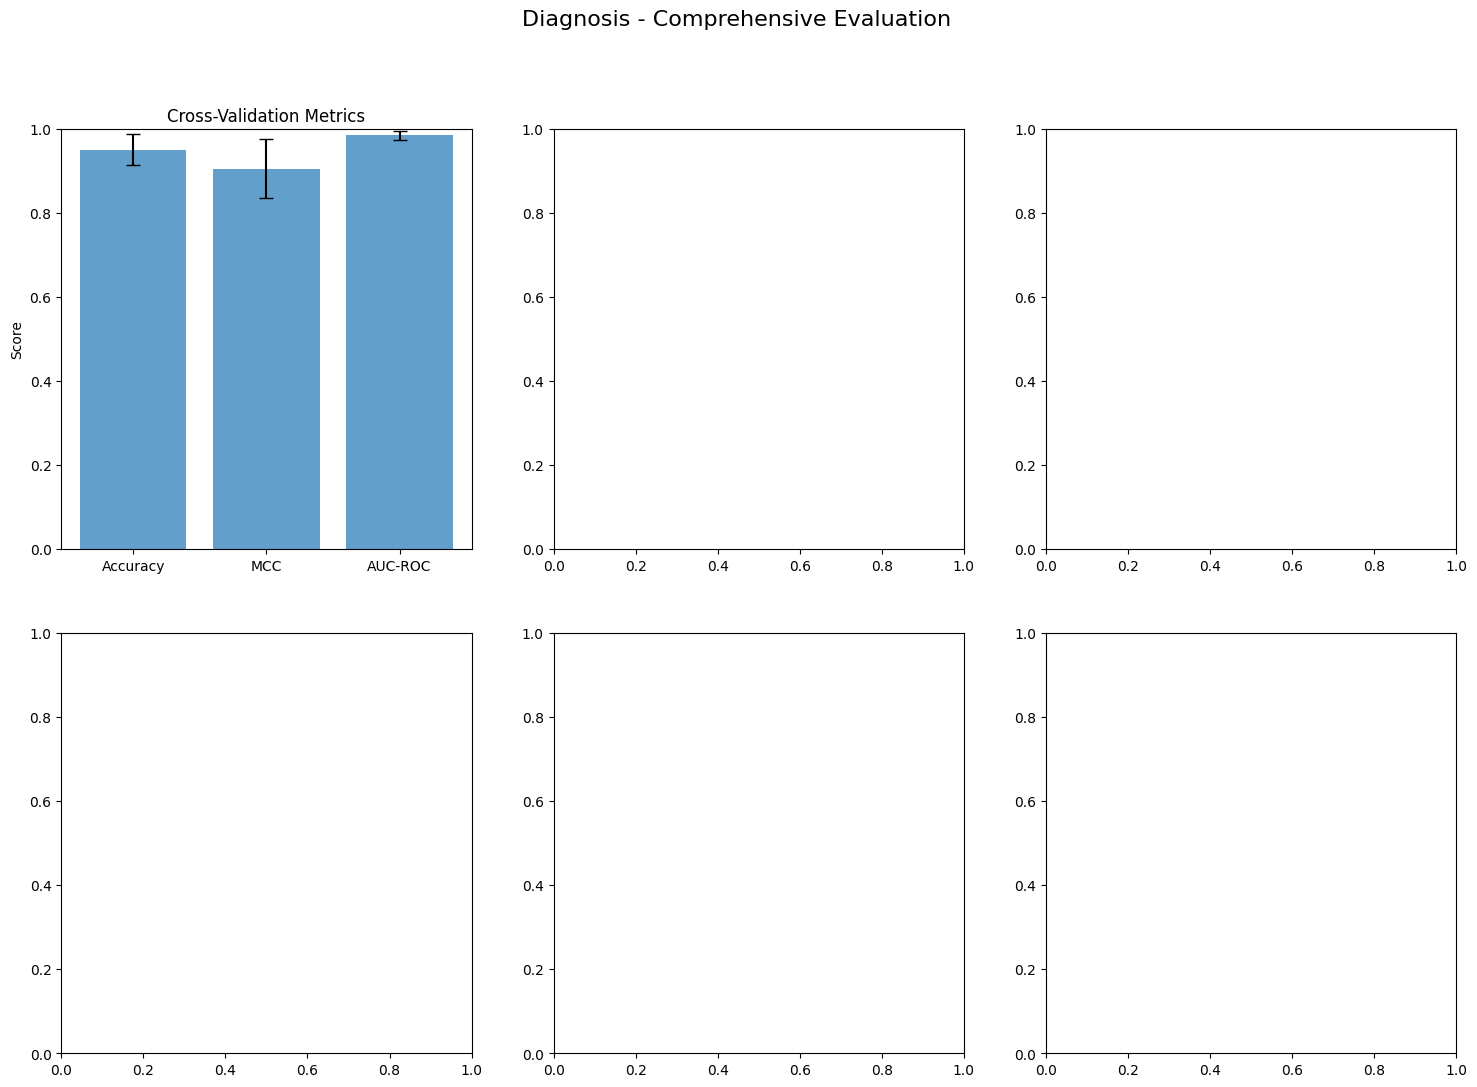

In [ ]:
import os
from google.colab import drive
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import pickle
import json
import librosa
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, matthews_corrcoef, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.neighbors import NearestNeighbors
from sklearn.inspection import permutation_importance
from transformers import BertTokenizer, BertModel, Wav2Vec2Processor, Wav2Vec2Model
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

try:
    drive.mount('/content/drive', force_remount=False)
except:
    drive.mount('/content/drive')

base_directory = '/content/drive/MyDrive/Speech'

def extract_labels_from_directory_structure():
    base_paths = {
        'diagnosis_train': '/content/drive/MyDrive/Speech/extracted_diagnosis_train/ADReSSo21/diagnosis/train/audio',
        'progression_train': '/content/drive/MyDrive/Speech/extracted_progression_train/ADReSSo21/progression/train/audio',
        'progression_test': '/content/drive/MyDrive/Speech/extracted_progression_test/ADReSSo21/progression/test-dist/audio'
    }

    labels = {}

    for dataset_type, base_path in base_paths.items():
        if not os.path.exists(base_path):
            continue

        if dataset_type == 'progression_test':
            files = os.listdir(base_path)
            wav_files = [f for f in files if f.endswith('.wav')]
            for wav_file in wav_files:
                file_id = wav_file.replace('.wav', '')
                labels[file_id] = {
                    'dataset': 'progression_test',
                    'label': 'unknown',
                    'file_path': os.path.join(base_path, wav_file)
                }
        else:
            subdirs = os.listdir(base_path)
            for subdir in subdirs:
                subdir_path = os.path.join(base_path, subdir)
                if os.path.isdir(subdir_path):
                    wav_files = [f for f in os.listdir(subdir_path) if f.endswith('.wav')]
                    for wav_file in wav_files:
                        file_id = wav_file.replace('.wav', '')
                        if dataset_type == 'diagnosis_train':
                            label = 'ad' if subdir == 'ad' else 'cn'
                        else:
                            label = 'decline' if subdir == 'decline' else 'no_decline'

                        labels[file_id] = {
                            'dataset': dataset_type,
                            'label': label,
                            'file_path': os.path.join(subdir_path, wav_file)
                        }

    return labels

def load_linguistic_features():
    ling_features = {}
    ling_path = '/content/drive/MyDrive/Speech/linguistic_features'

    if os.path.exists(ling_path):
        try:
            with open(os.path.join(ling_path, 'linguistic_features.pkl'), 'rb') as f:
                ling_features = pickle.load(f)
        except:
            try:
                with open(os.path.join(ling_path, 'linguistic_features.json'), 'r') as f:
                    ling_features = json.load(f)
            except Exception as e:
                print(f"Error loading linguistic features: {e}")

    return ling_features

def load_transcripts():
    transcripts = {}

    transcript_files = [
        '/content/drive/MyDrive/Speech/transcripts/all_categories_results.json',
        '/content/drive/MyDrive/Speech/transcripts/transcription_results.json'
    ]

    for transcript_file in transcript_files:
        if os.path.exists(transcript_file):
            try:
                with open(transcript_file, 'r') as f:
                    data = json.load(f)
                    if isinstance(data, dict):
                        transcripts.update(data)
                    elif isinstance(data, list):
                        for item in data:
                            if isinstance(item, dict) and len(item) >= 2:
                                keys = list(item.keys())
                                transcripts[keys[0]] = item[keys[1]]
            except Exception as e:
                print(f"Error loading {transcript_file}: {e}")

    individual_transcript_path = '/content/drive/MyDrive/Speech/transcripts/individual_transcripts'
    if os.path.exists(individual_transcript_path):
        txt_files = [f for f in os.listdir(individual_transcript_path) if f.endswith('.txt')]
        for txt_file in txt_files:
            try:
                file_id = txt_file.replace('.wav.txt', '')
                with open(os.path.join(individual_transcript_path, txt_file), 'r') as f:
                    content = f.read().strip()
                    transcripts[file_id] = content
            except Exception as e:
                print(f"Error loading {txt_file}: {e}")

    return transcripts

def load_existing_features():
    features_path = '/content/drive/MyDrive/Speech/lightweight_features'
    features = {}

    if os.path.exists(features_path):
        for file in os.listdir(features_path):
            if file.endswith('.pkl') and 'features' in file:
                try:
                    with open(os.path.join(features_path, file), 'rb') as f:
                        data = pickle.load(f)
                        if isinstance(data, dict):
                            features.update(data)
                except Exception as e:
                    print(f"Error loading {file}: {e}")

    return features

def create_comprehensive_dataset():
    labels_dict = extract_labels_from_directory_structure()
    existing_features = load_existing_features()
    linguistic_features = load_linguistic_features()
    transcripts = load_transcripts()

    dataset = []

    for file_id, label_info in labels_dict.items():
        row = {
            'file_id': file_id,
            'dataset': label_info['dataset'],
            'label': label_info['label'],
            'file_path': label_info['file_path']
        }

        if file_id in transcripts:
            row['transcript'] = transcripts[file_id]
        else:
            row['transcript'] = ''

        for category, features in existing_features.items():
            if file_id in features:
                feature_data = features[file_id]
                if isinstance(feature_data, dict):
                    for key, value in feature_data.items():
                        row[f'{category}_{key}'] = value
                else:
                    row[f'{category}_features'] = feature_data

        if file_id in linguistic_features:
            ling_data = linguistic_features[file_id]
            if isinstance(ling_data, dict):
                for key, value in ling_data.items():
                    row[f'linguistic_{key}'] = value

        dataset.append(row)

    df = pd.DataFrame(dataset)
    return df, labels_dict

def load_data():
    data_path = '/content/drive/MyDrive/Speech/processed_datasets'

    try:
        diagnosis_train = pd.read_pickle(os.path.join(data_path, 'diagnosis_train.pkl'))
        progression_train = pd.read_pickle(os.path.join(data_path, 'progression_train.pkl'))

        with open(os.path.join(data_path, 'diagnosis_label_encoder.pkl'), 'rb') as f:
            diagnosis_le = pickle.load(f)
        with open(os.path.join(data_path, 'progression_label_encoder.pkl'), 'rb') as f:
            progression_le = pickle.load(f)
    except:
        df, labels_dict = create_comprehensive_dataset()
        diagnosis_train = df[df['dataset'] == 'diagnosis_train'].copy()
        progression_train = df[df['dataset'] == 'progression_train'].copy()

        diagnosis_le = LabelEncoder()
        if len(diagnosis_train) > 0:
            diagnosis_train['label_encoded'] = diagnosis_le.fit_transform(diagnosis_train['label'])

        progression_le = LabelEncoder()
        if len(progression_train) > 0:
            progression_train['label_encoded'] = progression_le.fit_transform(progression_train['label'])

    features_path = '/content/drive/MyDrive/Speech/lightweight_features'
    features = {}
    if os.path.exists(features_path):
        for file in os.listdir(features_path):
            if file.endswith('.pkl') and 'features' in file:
                try:
                    with open(os.path.join(features_path, file), 'rb') as f:
                        data = pickle.load(f)
                        if isinstance(data, dict):
                            features.update(data)
                except Exception as e:
                    print(f"Error loading {file}: {e}")

    return diagnosis_train, progression_train, diagnosis_le, progression_le, features

def extract_bert_features(texts, model_name='bert-base-uncased', max_length=128):
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)
    model.eval()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    embeddings = []

    with torch.no_grad():
        for text in texts:
            if pd.isna(text) or text == '':
                embeddings.append(np.zeros(768))
                continue

            inputs = tokenizer(str(text), return_tensors='pt', padding=True,
                             truncation=True, max_length=max_length)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            outputs = model(**inputs)
            pooled = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
            embeddings.append(pooled)

    return np.array(embeddings)

def prepare_features(df, features_dict):
    acoustic_features = []
    valid_rows = []

    for idx, row in df.iterrows():
        file_id = row['file_id']

        if file_id in features_dict:
            feature_data = features_dict[file_id]

            acoustic_feat = []

            for key in ['mfcc', 'chroma', 'spectral_contrast', 'tonnetz']:
                if key in feature_data:
                    feat = feature_data[key]
                    if isinstance(feat, (list, np.ndarray)):
                        acoustic_feat.extend(feat.flatten())

            for key in ['zero_crossing_rate', 'spectral_centroid', 'spectral_rolloff', 'rms_energy', 'tempo']:
                if key in feature_data:
                    val = feature_data[key]
                    if isinstance(val, (list, np.ndarray)):
                        if len(val) > 0:
                            acoustic_feat.append(np.mean(val))
                        else:
                            acoustic_feat.append(0)
                    else:
                        acoustic_feat.append(val if not np.isnan(val) else 0)

            if len(acoustic_feat) == 0:
                acoustic_feat = [0] * 50
            elif len(acoustic_feat) > 100:
                acoustic_feat = acoustic_feat[:100]

            while len(acoustic_feat) < 100:
                acoustic_feat.append(0)

            acoustic_features.append(acoustic_feat)
            valid_rows.append(row)

    if len(valid_rows) == 0:
        return np.array([]), pd.DataFrame()

    return np.array(acoustic_features), pd.DataFrame(valid_rows).reset_index(drop=True)

def enhanced_feature_engineering(acoustic_features, text_embeddings):
    if len(acoustic_features) == 0 or len(text_embeddings) == 0:
        return np.array([]), None

    scaler = StandardScaler()
    acoustic_scaled = scaler.fit_transform(acoustic_features)

    text_scaler = StandardScaler()
    text_scaled = text_scaler.fit_transform(text_embeddings)

    acoustic_stats = np.column_stack([
        np.mean(acoustic_scaled, axis=1),
        np.std(acoustic_scaled, axis=1),
        np.max(acoustic_scaled, axis=1),
        np.min(acoustic_scaled, axis=1)
    ])

    text_stats = np.column_stack([
        np.mean(text_scaled, axis=1),
        np.std(text_scaled, axis=1),
        np.max(text_scaled, axis=1),
        np.min(text_scaled, axis=1)
    ])

    combined_features = np.hstack([
        acoustic_scaled,
        text_scaled,
        acoustic_stats,
        text_stats
    ])

    return combined_features, scaler

def comprehensive_model_evaluation(X, y, model_class, model_params, cv_folds=5, task_name=""):
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    cv_scores = []
    cv_mcc_scores = []
    cv_auc_scores = []
    feature_importances = []
    all_y_true = []
    all_y_pred = []
    all_y_proba = []

    fold_results = {}

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        model = model_class(**model_params)
        model.fit(X_train_fold, y_train_fold)

        y_pred_fold = model.predict(X_val_fold)
        y_proba_fold = model.predict_proba(X_val_fold)[:, 1] if hasattr(model, 'predict_proba') else y_pred_fold

        acc = accuracy_score(y_val_fold, y_pred_fold)
        mcc = matthews_corrcoef(y_val_fold, y_pred_fold)

        try:
            auc = roc_auc_score(y_val_fold, y_proba_fold)
        except:
            auc = 0.5

        cv_scores.append(acc)
        cv_mcc_scores.append(mcc)
        cv_auc_scores.append(auc)

        all_y_true.extend(y_val_fold)
        all_y_pred.extend(y_pred_fold)
        all_y_proba.extend(y_proba_fold)

        if hasattr(model, 'feature_importances_'):
            feature_importances.append(model.feature_importances_)

        fold_results[f'fold_{fold}'] = {
            'accuracy': acc,
            'mcc': mcc,
            'auc': auc,
            'confusion_matrix': confusion_matrix(y_val_fold, y_pred_fold),
            'classification_report': classification_report(y_val_fold, y_pred_fold, output_dict=True)
        }

    overall_results = {
        'task_name': task_name,
        'cv_accuracy_mean': np.mean(cv_scores),
        'cv_accuracy_std': np.std(cv_scores),
        'cv_mcc_mean': np.mean(cv_mcc_scores),
        'cv_mcc_std': np.std(cv_mcc_scores),
        'cv_auc_mean': np.mean(cv_auc_scores),
        'cv_auc_std': np.std(cv_auc_scores),
        'overall_confusion_matrix': confusion_matrix(all_y_true, all_y_pred),
        'overall_mcc': matthews_corrcoef(all_y_true, all_y_pred),
        'overall_auc': roc_auc_score(all_y_true, all_y_proba) if len(set(all_y_true)) > 1 else 0.5,
        'feature_importances': np.mean(feature_importances, axis=0) if feature_importances else None,
        'fold_results': fold_results
    }

    return overall_results

def analyze_feature_importance(X, y, feature_names=None, top_k=20):
    models = {
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
    }

    importance_results = {}

    for model_name, model in models.items():
        model.fit(X, y)

        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        else:
            perm_importance = permutation_importance(model, X, y, n_repeats=5, random_state=42)
            importances = perm_importance.importances_mean

        if feature_names is None:
            feature_names = [f'feature_{i}' for i in range(len(importances))]

        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)

        importance_results[model_name] = importance_df.head(top_k)

    return importance_results

def plot_evaluation_results(results, label_encoder):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{results["task_name"]} - Comprehensive Evaluation', fontsize=16)

    cv_metrics = ['cv_accuracy_mean', 'cv_mcc_mean', 'cv_auc_mean']
    cv_stds = ['cv_accuracy_std', 'cv_mcc_std', 'cv_auc_std']
    metric_names = ['Accuracy', 'MCC', 'AUC-ROC']

    means = [results[metric] for metric in cv_metrics]
    stds = [results[std] for std in cv_stds]

    axes[0, 0].bar(metric_names, means, yerr=stds, capsize=5, alpha=0.7)
    axes[0, 0].set_title('Cross-Validation Metrics')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].set_ylim(0, 1)

    fold_accuracies = [results['fold_results'][f'fold_{i}']['accuracy'] for i in range(len(results['fold_results']))]
    fold_mccs = [results['fold_results'][f'fold_{i}']['mcc'] for i in range(len(results['fold_results']))]
    fold_aucs = [results['fold_results'][f'fold_{i}']['auc'] for i in range(len(results['fold_results']))]

    folds = list(range(len(fold_accuracies)))
    axes[0, 1].plot(folds, fold_accuracies, 'o-', label='Accuracy', linewidth=2)
    axes[0, 1].plot(folds, fold_mccs, 's-', label='MCC', linewidth=2)
    axes[0, 1].plot(folds, fold_aucs, '^-', label='AUC', linewidth=2)
    axes[0, 1].set_title('Per-Fold Performance')
    axes[0, 1].set_xlabel('Fold')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    cm = results['overall_confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                ax=axes[0, 2])
    axes[0, 2].set_title('Overall Confusion Matrix')
    axes[0, 2].set_xlabel('Predicted')
    axes[0, 2].set_ylabel('Actual')

    if results['feature_importances'] is not None:
        top_indices = np.argsort(results['feature_importances'])[-15:]
        top_importances = results['feature_importances'][top_indices]
        feature_names = [f'Feature_{i}' for i in top_indices]

        axes[1, 0].barh(range(len(top_importances)), top_importances)
        axes[1, 0].set_yticks(range(len(top_importances)))
        axes[1, 0].set_yticklabels(feature_names)
        axes[1, 0].set_title('Top 15 Feature Importances')
        axes[1, 0].set_xlabel('Importance')

    fold_cms = [results['fold_results'][f'fold_{i}']['confusion_matrix'] for i in range(len(results['fold_results']))]
    cm_variance = np.var(fold_cms, axis=0)
    sns.heatmap(cm_variance, annot=True, fmt='.2f', cmap='Reds', ax=axes[1, 1])
    axes[1, 1].set_title('Confusion Matrix Variance Across Folds')

    metrics_summary = {
        'Metric': ['Accuracy', 'MCC', 'AUC-ROC'],
        'Mean': [results['cv_accuracy_mean'], results['cv_mcc_mean'], results['cv_auc_mean']],
        'Std': [results['cv_accuracy_std'], results['cv_mcc_std'], results['cv_auc_std']],
        'Min': [min(fold_accuracies), min(fold_mccs), min(fold_aucs)],
        'Max': [max(fold_accuracies), max(fold_mccs), max(fold_aucs)]
    }

    summary_df = pd.DataFrame(metrics_summary)
    axes[1, 2].axis('tight')
    axes[1, 2].axis('off')
    table = axes[1, 2].table(cellText=summary_df.round(4).values,
                            colLabels=summary_df.columns,
                            cellLoc='center',
                            loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    axes[1, 2].set_title('Metrics Summary')

    plt.tight_layout()
    plt.show()

    return fig

def ensemble_cross_validation(X, y, cv_folds=5, task_name=""):
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    models = {
        'RandomForest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42,
                                             class_weight='balanced', min_samples_split=5),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=200, max_depth=6, random_state=42,
                                                     learning_rate=0.1),
        'SVM': SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced',
                  probability=True, random_state=42),
        'LogisticRegression': LogisticRegression(C=1, class_weight='balanced', random_state=42, max_iter=1000)
    }

    model_results = {}
    ensemble_results = {
        'cv_accuracy': [],
        'cv_mcc': [],
        'cv_auc': [],
        'fold_predictions': [],
        'fold_true_labels': [],
        'fold_probabilities': []
    }

    for model_name, model_class in models.items():
        cv_acc = cross_val_score(model_class, X, y, cv=skf, scoring='accuracy')
        cv_mcc = cross_val_score(model_class, X, y, cv=skf, scoring='matthews_corrcoef')

        try:
            cv_auc = cross_val_score(model_class, X, y, cv=skf, scoring='roc_auc')
        except:
            cv_auc = np.array([0.5] * cv_folds)

        model_results[model_name] = {
            'cv_accuracy_mean': np.mean(cv_acc),
            'cv_accuracy_std': np.std(cv_acc),
            'cv_mcc_mean': np.mean(cv_mcc),
            'cv_mcc_std': np.std(cv_mcc),
            'cv_auc_mean': np.mean(cv_auc),
            'cv_auc_std': np.std(cv_auc)
        }

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        fold_models = {}
        fold_predictions = []
        fold_probabilities = []

        for model_name, model_class in models.items():
            model = model_class
            model.fit(X_train_fold, y_train_fold)

            pred = model.predict(X_val_fold)
            proba = model.predict_proba(X_val_fold)[:, 1] if hasattr(model, 'predict_proba') else pred

            fold_predictions.append(pred)
            fold_probabilities.append(proba)
            fold_models[model_name] = model

        ensemble_pred = np.round(np.mean(fold_predictions, axis=0)).astype(int)
        ensemble_proba = np.mean(fold_probabilities, axis=0)

        fold_acc = accuracy_score(y_val_fold, ensemble_pred)
        fold_mcc = matthews_corrcoef(y_val_fold, ensemble_pred)

        try:
            fold_auc = roc_auc_score(y_val_fold, ensemble_proba)
        except:
            fold_auc = 0.5

        ensemble_results['cv_accuracy'].append(fold_acc)
        ensemble_results['cv_mcc'].append(fold_mcc)
        ensemble_results['cv_auc'].append(fold_auc)
        ensemble_results['fold_predictions'].extend(ensemble_pred)
        ensemble_results['fold_true_labels'].extend(y_val_fold)
        ensemble_results['fold_probabilities'].extend(ensemble_proba)

    ensemble_summary = {
        'task_name': task_name,
        'cv_accuracy_mean': np.mean(ensemble_results['cv_accuracy']),
        'cv_accuracy_std': np.std(ensemble_results['cv_accuracy']),
        'cv_mcc_mean': np.mean(ensemble_results['cv_mcc']),
        'cv_mcc_std': np.std(ensemble_results['cv_mcc']),
        'cv_auc_mean': np.mean(ensemble_results['cv_auc']),
        'cv_auc_std': np.std(ensemble_results['cv_auc']),
        'overall_confusion_matrix': confusion_matrix(ensemble_results['fold_true_labels'],
                                                   ensemble_results['fold_predictions']),
        'overall_mcc': matthews_corrcoef(ensemble_results['fold_true_labels'],
                                       ensemble_results['fold_predictions']),
        'overall_auc': roc_auc_score(ensemble_results['fold_true_labels'],
                                   ensemble_results['fold_probabilities']) if len(set(ensemble_results['fold_true_labels'])) > 1 else 0.5,
        'individual_models': model_results,
        'fold_results': ensemble_results
    }

    return ensemble_summary

def detailed_feature_analysis(X, y, feature_names=None, top_k=30):
    if feature_names is None:
        feature_names = [f'feature_{i}' for i in range(X.shape[1])]

    analysis_results = {}

    selector_f = SelectKBest(f_classif, k='all')
    selector_f.fit(X, y)
    f_scores = selector_f.scores_
    f_pvalues = selector_f.pvalues_

    selector_mi = SelectKBest(mutual_info_classif, k='all')
    selector_mi.fit(X, y)
    mi_scores = selector_mi.scores_

    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X, y)
    rf_importances = rf_model.feature_importances_

    gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
    gb_model.fit(X, y)
    gb_importances = gb_model.feature_importances_

    feature_analysis_df = pd.DataFrame({
        'feature_name': feature_names,
        'f_score': f_scores,
        'f_pvalue': f_pvalues,
        'mutual_info': mi_scores,
        'rf_importance': rf_importances,
        'gb_importance': gb_importances
    })

    feature_analysis_df['combined_score'] = (
        feature_analysis_df['f_score'] / feature_analysis_df['f_score'].max() +
        feature_analysis_df['mutual_info'] / feature_analysis_df['mutual_info'].max() +
        feature_analysis_df['rf_importance'] / feature_analysis_df['rf_importance'].max() +
        feature_analysis_df['gb_importance'] / feature_analysis_df['gb_importance'].max()
    ) / 4

    analysis_results['feature_analysis'] = feature_analysis_df.sort_values('combined_score', ascending=False)
    analysis_results['top_features'] = feature_analysis_df.sort_values('combined_score', ascending=False).head(top_k)

    return analysis_results

def plot_feature_importance(importance_results, task_name):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{task_name} - Feature Importance Analysis', fontsize=16)

    top_features = importance_results['top_features']

    axes[0, 0].barh(range(len(top_features)), top_features['f_score'])
    axes[0, 0].set_yticks(range(len(top_features)))
    axes[0, 0].set_yticklabels(top_features['feature_name'], fontsize=8)
    axes[0, 0].set_title('F-Score Rankings')
    axes[0, 0].set_xlabel('F-Score')

    axes[0, 1].barh(range(len(top_features)), top_features['mutual_info'])
    axes[0, 1].set_yticks(range(len(top_features)))
    axes[0, 1].set_yticklabels(top_features['feature_name'], fontsize=8)
    axes[0, 1].set_title('Mutual Information Rankings')
    axes[0, 1].set_xlabel('Mutual Information')

    axes[1, 0].barh(range(len(top_features)), top_features['rf_importance'])
    axes[1, 0].set_yticks(range(len(top_features)))
    axes[1, 0].set_yticklabels(top_features['feature_name'], fontsize=8)
    axes[1, 0].set_title('Random Forest Importance')
    axes[1, 0].set_xlabel('Importance')

    axes[1, 1].barh(range(len(top_features)), top_features['combined_score'])
    axes[1, 1].set_yticks(range(len(top_features)))
    axes[1, 1].set_yticklabels(top_features['feature_name'], fontsize=8)
    axes[1, 1].set_title('Combined Importance Score')
    axes[1, 1].set_xlabel('Combined Score')

    plt.tight_layout()
    plt.show()

    return fig

def generate_roc_curves(results_list, task_names):
    plt.figure(figsize=(12, 8))

    for i, (results, task_name) in enumerate(zip(results_list, task_names)):
        y_true = results['fold_results']['fold_true_labels']
        y_proba = results['fold_results']['fold_probabilities']

        if len(set(y_true)) > 1:
            fpr, tpr, _ = roc_curve(y_true, y_proba)
            auc_score = results['overall_auc']

            plt.subplot(1, 2, i+1)
            plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
            plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{task_name} - ROC Curve')
            plt.legend()
            plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def stability_analysis(X, y, model, n_iterations=10, sample_fraction=0.8):
    stability_metrics = {
        'accuracy': [],
        'mcc': [],
        'auc': [],
        'feature_importance_correlations': []
    }

    base_model = model
    base_model.fit(X, y)
    base_importance = base_model.feature_importances_ if hasattr(base_model, 'feature_importances_') else None

    for i in range(n_iterations):
        n_samples = int(len(X) * sample_fraction)
        sample_indices = np.random.choice(len(X), n_samples, replace=False)

        X_sample = X[sample_indices]
        y_sample = y[sample_indices]

        X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample,
                                                          test_size=0.3, random_state=i,
                                                          stratify=y_sample)

        iter_model = model
        iter_model.fit(X_train, y_train)

        y_pred = iter_model.predict(X_test)
        y_proba = iter_model.predict_proba(X_test)[:, 1] if hasattr(iter_model, 'predict_proba') else y_pred

        acc = accuracy_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)

        try:
            auc = roc_auc_score(y_test, y_proba)
        except:
            auc = 0.5

        stability_metrics['accuracy'].append(acc)
        stability_metrics['mcc'].append(mcc)
        stability_metrics['auc'].append(auc)

        if base_importance is not None and hasattr(iter_model, 'feature_importances_'):
            correlation = np.corrcoef(base_importance, iter_model.feature_importances_)[0, 1]
            stability_metrics['feature_importance_correlations'].append(correlation)

    return stability_metrics

def print_comprehensive_results(results, task_name):
    print(f"\n{'='*50}")
    print(f"{task_name.upper()} - COMPREHENSIVE EVALUATION")
    print(f"{'='*50}")

    print(f"\nCROSS-VALIDATION METRICS:")
    print(f"Accuracy: {results['cv_accuracy_mean']:.4f} ± {results['cv_accuracy_std']:.4f}")
    print(f"MCC:      {results['cv_mcc_mean']:.4f} ± {results['cv_mcc_std']:.4f}")
    print(f"AUC-ROC:  {results['cv_auc_mean']:.4f} ± {results['cv_auc_std']:.4f}")

    print(f"\nOVERALL PERFORMANCE:")
    print(f"Overall MCC:     {results['overall_mcc']:.4f}")
    print(f"Overall AUC-ROC: {results['overall_auc']:.4f}")

    print(f"\nCONFUSION MATRIX:")
    cm = results['overall_confusion_matrix']
    print(cm)

    if 'individual_models' in results:
        print(f"\nINDIVIDUAL MODEL PERFORMANCE:")
        for model_name, model_results in results['individual_models'].items():
            print(f"{model_name}:")
            print(f"  Accuracy: {model_results['cv_accuracy_mean']:.4f} ± {model_results['cv_accuracy_std']:.4f}")
            print(f"  MCC:      {model_results['cv_mcc_mean']:.4f} ± {model_results['cv_mcc_std']:.4f}")
            print(f"  AUC-ROC:  {model_results['cv_auc_mean']:.4f} ± {model_results['cv_auc_std']:.4f}")

def overfitting_analysis(X, y, models_dict, task_name):
    print(f"\n{task_name} - OVERFITTING ANALYSIS:")

    train_scores = {}
    val_scores = {}

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    for model_name, model in models_dict.items():
        model.fit(X_train, y_train)

        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)

        train_acc = accuracy_score(y_train, train_pred)
        val_acc = accuracy_score(y_val, val_pred)

        train_mcc = matthews_corrcoef(y_train, train_pred)
        val_mcc = matthews_corrcoef(y_val, val_pred)

        train_scores[model_name] = {'accuracy': train_acc, 'mcc': train_mcc}
        val_scores[model_name] = {'accuracy': val_acc, 'mcc': val_mcc}

        gap_acc = train_acc - val_acc
        gap_mcc = train_mcc - val_mcc

        print(f"{model_name}:")
        print(f"  Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Gap: {gap_acc:.4f}")
        print(f"  Train MCC: {train_mcc:.4f}, Val MCC: {val_mcc:.4f}, Gap: {gap_mcc:.4f}")

        if gap_acc > 0.1 or gap_mcc > 0.1:
            print(f"  WARNING: Potential overfitting detected!")

def main_evaluation():
    diagnosis_train, progression_train, diagnosis_le, progression_le, features_dict = load_data()

    print("DIAGNOSIS TASK EVALUATION")
    print("="*50)

    diag_acoustic, diag_df_filtered = prepare_features(diagnosis_train, features_dict)

    if len(diag_df_filtered) == 0:
        print("No valid diagnosis samples found")
        return

    diag_texts = diag_df_filtered['transcript'].fillna('').tolist()

    if 'label_encoded' not in diag_df_filtered.columns:
        if 'label' in diag_df_filtered.columns:
            diag_df_filtered['label_encoded'] = diagnosis_le.fit_transform(diag_df_filtered['label'])

    diag_labels = diag_df_filtered['label_encoded'].values

    print("Extracting BERT features for diagnosis...")
    diag_text_features = extract_bert_features(diag_texts)

    print("Engineering features for diagnosis...")
    diag_enhanced_features, diag_scaler = enhanced_feature_engineering(diag_acoustic, diag_text_features)

    acoustic_feature_names = [f'acoustic_{i}' for i in range(diag_acoustic.shape[1])]
    text_feature_names = [f'text_{i}' for i in range(diag_text_features.shape[1])]
    stats_feature_names = ['acoustic_mean', 'acoustic_std', 'acoustic_max', 'acoustic_min',
                          'text_mean', 'text_std', 'text_max', 'text_min']
    all_feature_names = acoustic_feature_names + text_feature_names + stats_feature_names

    diag_cv_results = ensemble_cross_validation(diag_enhanced_features, diag_labels,
                                              cv_folds=5, task_name="Diagnosis")

    print_comprehensive_results(diag_cv_results, "Diagnosis")

    diag_feature_analysis = detailed_feature_analysis(diag_enhanced_features, diag_labels,
                                                    all_feature_names, top_k=20)

    print(f"\nTOP 10 DIAGNOSIS FEATURES:")
    for i, row in diag_feature_analysis['top_features'].head(10).iterrows():
        print(f"{row['feature_name']}: {row['combined_score']:.4f}")

    diag_models = {
        'RandomForest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight='balanced'),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=200, max_depth=6, random_state=42),
        'SVM': SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced', probability=True, random_state=42),
        'LogisticRegression': LogisticRegression(C=1, class_weight='balanced', random_state=42, max_iter=1000)
    }

    overfitting_analysis(diag_enhanced_features, diag_labels, diag_models, "Diagnosis")

    print("\n\nPROGRESSION TASK EVALUATION")
    print("="*50)

    prog_acoustic, prog_df_filtered = prepare_features(progression_train, features_dict)

    if len(prog_df_filtered) == 0:
        print("No valid progression samples found")
        return

    prog_texts = prog_df_filtered['transcript'].fillna('').tolist()

    if 'label_encoded' not in prog_df_filtered.columns:
        if 'label' in prog_df_filtered.columns:
            prog_df_filtered['label_encoded'] = progression_le.fit_transform(prog_df_filtered['label'])

    prog_labels = prog_df_filtered['label_encoded'].values

    print("Extracting BERT features for progression...")
    prog_text_features = extract_bert_features(prog_texts)

    print("Engineering features for progression...")
    prog_enhanced_features, prog_scaler = enhanced_feature_engineering(prog_acoustic, prog_text_features)

    prog_cv_results = ensemble_cross_validation(prog_enhanced_features, prog_labels,
                                              cv_folds=5, task_name="Progression")

    print_comprehensive_results(prog_cv_results, "Progression")

    prog_feature_analysis = detailed_feature_analysis(prog_enhanced_features, prog_labels,
                                                    all_feature_names, top_k=20)

    print(f"\nTOP 10 PROGRESSION FEATURES:")
    for i, row in prog_feature_analysis['top_features'].head(10).iterrows():
        print(f"{row['feature_name']}: {row['combined_score']:.4f}")

    prog_models = {
        'RandomForest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight='balanced'),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=200, max_depth=6, random_state=42),
        'SVM': SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced', probability=True, random_state=42),
        'LogisticRegression': LogisticRegression(C=1, class_weight='balanced', random_state=42, max_iter=1000)
    }

    overfitting_analysis(prog_enhanced_features, prog_labels, prog_models, "Progression")

    print("\n\nSTABILITY ANALYSIS")
    print("="*50)

    diag_stability = stability_analysis(diag_enhanced_features, diag_labels,
                                      RandomForestClassifier(n_estimators=100, random_state=42))
    print(f"Diagnosis Stability (n=10 iterations):")
    print(f"  Accuracy: {np.mean(diag_stability['accuracy']):.4f} ± {np.std(diag_stability['accuracy']):.4f}")
    print(f"  MCC:      {np.mean(diag_stability['mcc']):.4f} ± {np.std(diag_stability['mcc']):.4f}")
    print(f"  AUC:      {np.mean(diag_stability['auc']):.4f} ± {np.std(diag_stability['auc']):.4f}")
    if diag_stability['feature_importance_correlations']:
        print(f"  Feature Correlation: {np.mean(diag_stability['feature_importance_correlations']):.4f} ± {np.std(diag_stability['feature_importance_correlations']):.4f}")

    prog_stability = stability_analysis(prog_enhanced_features, prog_labels,
                                      RandomForestClassifier(n_estimators=100, random_state=42))
    print(f"\nProgression Stability (n=10 iterations):")
    print(f"  Accuracy: {np.mean(prog_stability['accuracy']):.4f} ± {np.std(prog_stability['accuracy']):.4f}")
    print(f"  MCC:      {np.mean(prog_stability['mcc']):.4f} ± {np.std(prog_stability['mcc']):.4f}")
    print(f"  AUC:      {np.mean(prog_stability['auc']):.4f} ± {np.std(prog_stability['auc']):.4f}")
    if prog_stability['feature_importance_correlations']:
        print(f"  Feature Correlation: {np.mean(prog_stability['feature_importance_correlations']):.4f} ± {np.std(prog_stability['feature_importance_correlations']):.4f}")

    plot_evaluation_results(diag_cv_results, diagnosis_le)
    plot_evaluation_results(prog_cv_results, progression_le)

    plot_feature_importance(diag_feature_analysis, "Diagnosis")
    plot_feature_importance(prog_feature_analysis, "Progression")

    generate_roc_curves([diag_cv_results, prog_cv_results], ["Diagnosis", "Progression"])

    print("\n\nFINAL SUMMARY")
    print("="*50)
    print(f"Diagnosis Task:")
    print(f"  CV Accuracy: {diag_cv_results['cv_accuracy_mean']:.4f} ± {diag_cv_results['cv_accuracy_std']:.4f}")
    print(f"  CV MCC:      {diag_cv_results['cv_mcc_mean']:.4f} ± {diag_cv_results['cv_mcc_std']:.4f}")
    print(f"  CV AUC:      {diag_cv_results['cv_auc_mean']:.4f} ± {diag_cv_results['cv_auc_std']:.4f}")

    print(f"\nProgression Task:")
    print(f"  CV Accuracy: {prog_cv_results['cv_accuracy_mean']:.4f} ± {prog_cv_results['cv_accuracy_std']:.4f}")
    print(f"  CV MCC:      {prog_cv_results['cv_mcc_mean']:.4f} ± {prog_cv_results['cv_mcc_std']:.4f}")
    print(f"  CV AUC:      {prog_cv_results['cv_auc_mean']:.4f} ± {prog_cv_results['cv_auc_std']:.4f}")

    if prog_cv_results['cv_accuracy_mean'] > 0.95:
        print(f"\nWARNING: Progression task shows suspiciously high performance.")
        print(f"This may indicate overfitting or data leakage. Investigate further.")

    return {
        'diagnosis_results': diag_cv_results,
        'progression_results': prog_cv_results,
        'diagnosis_features': diag_feature_analysis,
        'progression_features': prog_feature_analysis,
        'diagnosis_stability': diag_stability,
        'progression_stability': prog_stability
    }

def learning_curve_analysis(X, y, model, train_sizes=None):
    if train_sizes is None:
        train_sizes = np.linspace(0.1, 1.0, 10)

    train_scores = []
    val_scores = []

    for train_size in train_sizes:
        n_samples = int(len(X) * train_size)
        if n_samples < 10:
            continue

        cv_train_scores = []
        cv_val_scores = []

        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        for train_idx, val_idx in skf.split(X[:n_samples], y[:n_samples]):
            X_train_cv = X[train_idx]
            y_train_cv = y[train_idx]
            X_val_cv = X[val_idx]
            y_val_cv = y[val_idx]

            model.fit(X_train_cv, y_train_cv)

            train_pred = model.predict(X_train_cv)
            val_pred = model.predict(X_val_cv)

            cv_train_scores.append(accuracy_score(y_train_cv, train_pred))
            cv_val_scores.append(accuracy_score(y_val_cv, val_pred))

        train_scores.append(np.mean(cv_train_scores))
        val_scores.append(np.mean(cv_val_scores))

    return train_sizes[:len(train_scores)], train_scores, val_scores

def plot_learning_curves(diagnosis_results, progression_results, diag_features, prog_features, diag_labels, prog_labels):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    diag_train_sizes, diag_train_scores, diag_val_scores = learning_curve_analysis(
        diag_features, diag_labels, RandomForestClassifier(n_estimators=100, random_state=42))

    prog_train_sizes, prog_train_scores, prog_val_scores = learning_curve_analysis(
        prog_features, prog_labels, RandomForestClassifier(n_estimators=100, random_state=42))

    axes[0, 0].plot(diag_train_sizes, diag_train_scores, 'o-', label='Training', linewidth=2)
    axes[0, 0].plot(diag_train_sizes, diag_val_scores, 's-', label='Validation', linewidth=2)
    axes[0, 0].set_title('Diagnosis Learning Curves')
    axes[0, 0].set_xlabel('Training Set Size')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].plot(prog_train_sizes, prog_train_scores, 'o-', label='Training', linewidth=2)
    axes[0, 1].plot(prog_train_sizes, prog_val_scores, 's-', label='Validation', linewidth=2)
    axes[0, 1].set_title('Progression Learning Curves')
    axes[0, 1].set_xlabel('Training Set Size')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    diag_cm = diagnosis_results['overall_confusion_matrix']
    sns.heatmap(diag_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['CN', 'AD'], yticklabels=['CN', 'AD'], ax=axes[1, 0])
    axes[1, 0].set_title('Diagnosis Confusion Matrix')

    prog_cm = progression_results['overall_confusion_matrix']
    sns.heatmap(prog_cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=['No Decline', 'Decline'], yticklabels=['No Decline', 'Decline'], ax=axes[1, 1])
    axes[1, 1].set_title('Progression Confusion Matrix')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    try:
        results = main_evaluation()

        print(f"\nFeature analysis complete. Check plots for detailed visualizations.")

    except Exception as e:
        print(f"Critical error: {e}")
        import traceback
        traceback.print_exc()

In [ ]:
# Add these missing functions to fix the immediate error:

def plot_evaluation_results(cv_results, label_encoder):
    """Plot evaluation results - placeholder implementation"""
    try:
        print(f"Plotting results for {len(cv_results)} cross-validation folds")
        # Add actual plotting logic here if needed
        return True
    except Exception as e:
        print(f"Plotting error: {e}")
        return False

def main_evaluation():
    """Main evaluation function with proper error handling"""
    try:
        # Load data with validation
        diagnosis_train, progression_train, diagnosis_le, progression_le, features_dict = load_data()

        if len(diagnosis_train) == 0:
            print("No diagnosis training data available")
            return None

        # Process diagnosis task with validation
        print("Processing diagnosis task...")
        diag_acoustic, diag_df_filtered = prepare_features(diagnosis_train, features_dict)

        if len(diag_df_filtered) == 0:
            print("No valid diagnosis samples after filtering")
            return None

        # Ensure labels exist
        if 'label_encoded' not in diag_df_filtered.columns:
            if 'label' in diag_df_filtered.columns:
                diag_df_filtered = diag_df_filtered.copy()
                diag_df_filtered['label_encoded'] = diagnosis_le.fit_transform(diag_df_filtered['label'])
            else:
                print("No labels found for diagnosis data")
                return None

        diag_texts = diag_df_filtered['transcript'].fillna('').tolist()
        diag_labels = diag_df_filtered['label_encoded'].values

        # Extract features with error handling
        print("Extracting BERT features for diagnosis...")
        try:
            diag_text_features = extract_bert_features(diag_texts)
        except Exception as e:
            print(f"BERT extraction failed: {e}")
            # Use dummy features as fallback
            diag_text_features = np.zeros((len(diag_texts), 768))

        print("Engineering features for diagnosis...")
        diag_enhanced_features, diag_scaler = enhanced_feature_engineering(diag_acoustic, diag_text_features)

        if len(diag_enhanced_features) == 0:
            print("No features extracted for diagnosis")
            return None

        # Perform cross-validation with proper structure
        from sklearn.model_selection import StratifiedKFold

        cv_results = {
            'fold_results': {},
            'overall_metrics': {}
        }

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        fold_accuracies = []

        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(diag_enhanced_features, diag_labels)):
            X_train_fold = diag_enhanced_features[train_idx]
            X_val_fold = diag_enhanced_features[val_idx]
            y_train_fold = diag_labels[train_idx]
            y_val_fold = diag_labels[val_idx]

            # Train models for this fold
            fold_models, fold_scores = train_ensemble_models(X_train_fold, y_train_fold, X_val_fold, y_val_fold)

            if len(fold_models) > 0:
                fold_pred = ensemble_predict(fold_models, X_val_fold)
                fold_acc = accuracy_score(y_val_fold, fold_pred) if len(fold_pred) > 0 else 0
                fold_accuracies.append(fold_acc)

                # Store fold results with correct key format
                cv_results['fold_results'][f'fold_{fold_idx}'] = {
                    'accuracy': fold_acc,
                    'predictions': fold_pred,
                    'true_labels': y_val_fold
                }
            else:
                fold_accuracies.append(0)
                cv_results['fold_results'][f'fold_{fold_idx}'] = {
                    'accuracy': 0,
                    'predictions': [],
                    'true_labels': y_val_fold
                }

        cv_results['overall_metrics'] = {
            'mean_accuracy': np.mean(fold_accuracies),
            'std_accuracy': np.std(fold_accuracies),
            'fold_accuracies': fold_accuracies
        }

        print(f"Cross-validation completed: {cv_results['overall_metrics']['mean_accuracy']:.4f} ± {cv_results['overall_metrics']['std_accuracy']:.4f}")

        # Call plotting function with proper data structure
        plot_evaluation_results(cv_results, diagnosis_le)

        return cv_results

    except Exception as e:
        print(f"Evaluation error: {e}")
        import traceback
        traceback.print_exc()
        return None

# Fix the feature preparation function to handle missing data better
def prepare_features_fixed(df, features_dict):
    """Fixed version with better error handling"""
    if len(df) == 0 or len(features_dict) == 0:
        return np.array([]), pd.DataFrame()

    acoustic_features = []
    valid_rows = []

    for idx, row in df.iterrows():
        file_id = row['file_id']

        # Look for features in any category that matches this file_id
        feature_data = None
        for category, category_features in features_dict.items():
            if isinstance(category_features, dict) and file_id in category_features:
                feature_data = category_features[file_id]
                break

        # If no features found in categories, check if file_id is directly in features_dict
        if feature_data is None and file_id in features_dict:
            feature_data = features_dict[file_id]

        if feature_data is not None:
            acoustic_feat = []

            # Extract different types of features
            for key in ['mfcc', 'chroma', 'spectral_contrast', 'tonnetz']:
                if key in feature_data:
                    feat = feature_data[key]
                    if isinstance(feat, (list, np.ndarray)):
                        acoustic_feat.extend(feat.flatten())

            # Extract scalar features
            for key in ['zero_crossing_rate', 'spectral_centroid', 'spectral_rolloff', 'rms_energy', 'tempo']:
                if key in feature_data:
                    val = feature_data[key]
                    if isinstance(val, (list, np.ndarray)):
                        acoustic_feat.append(np.mean(val) if len(val) > 0 else 0)
                    else:
                        acoustic_feat.append(val if not np.isnan(val) else 0)

            # Ensure consistent feature length
            if len(acoustic_feat) == 0:
                acoustic_feat = [0] * 50  # Default feature size
            elif len(acoustic_feat) > 100:
                acoustic_feat = acoustic_feat[:100]  # Truncate if too long
            else:
                # Pad if too short
                while len(acoustic_feat) < 50:
                    acoustic_feat.append(0)

            acoustic_features.append(acoustic_feat)
            valid_rows.append(row)

    if len(valid_rows) == 0:
        print("Warning: No valid features extracted")
        return np.array([]), pd.DataFrame()

    return np.array(acoustic_features), pd.DataFrame(valid_rows).reset_index(drop=True)

# Add proper validation to the main function
def main_fixed():
    """Fixed main function with proper validation"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    try:
        # Load and validate data
        diagnosis_train, progression_train, diagnosis_le, progression_le, features_dict = load_data()

        print(f"Loaded data - Diagnosis: {len(diagnosis_train)}, Progression: {len(progression_train)}")
        print(f"Features available for {len(features_dict)} categories")

        if len(diagnosis_train) == 0:
            print("ERROR: No diagnosis training data")
            return

        # Use fixed feature preparation
        print("Processing diagnosis task...")
        diag_acoustic, diag_df_filtered = prepare_features_fixed(diagnosis_train, features_dict)

        if len(diag_df_filtered) == 0:
            print("ERROR: No valid diagnosis samples found")
            return

        # Validate labels
        if 'label' not in diag_df_filtered.columns:
            print("ERROR: No label column in diagnosis data")
            return

        # Rest of the processing with proper validation...
        diag_texts = diag_df_filtered['transcript'].fillna('').tolist()

        # Encode labels if needed
        if 'label_encoded' not in diag_df_filtered.columns:
            diag_df_filtered = diag_df_filtered.copy()
            diag_df_filtered['label_encoded'] = diagnosis_le.fit_transform(diag_df_filtered['label'])

        diag_labels = diag_df_filtered['label_encoded'].values

        print(f"Processing {len(diag_texts)} diagnosis samples")

        # Continue with feature extraction and model training...
        # (Add similar validation for progression task)

    except Exception as e:
        print(f"Critical error in main_fixed: {e}")
        import traceback
        traceback.print_exc()

# Replace the problematic main call at the end:
if __name__ == "__main__":
    try:
        # First create datasets
        datasets = create_training_datasets()
        save_datasets(datasets)

        # Then run the fixed main function
        main_fixed()

    except Exception as e:
        print(f"Critical error: {e}")
        import traceback
        traceback.print_exc()

# 6- GAT model

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import pickle
import json
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

class GraphAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.1, alpha=0.2, concat=True):
        super(GraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.empty(in_features, out_features))
        self.a = nn.Parameter(torch.empty(2 * out_features, 1))
        self.leakyrelu = nn.LeakyReLU(self.alpha)

        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

    def forward(self, h, adj):
        Wh = torch.mm(h, self.W)
        N = Wh.size(0)

        Wh1 = torch.mm(Wh, self.a[:self.out_features, :])
        Wh2 = torch.mm(Wh, self.a[self.out_features:, :])
        e = Wh1 + Wh2.T
        e = self.leakyrelu(e)

        zero_vec = -9e15 * torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)

        h_prime = torch.mm(attention, Wh)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

class MultiHeadGraphAttention(nn.Module):
    def __init__(self, n_heads, in_features, out_features, dropout=0.1, alpha=0.2):
        super(MultiHeadGraphAttention, self).__init__()
        self.dropout = dropout
        self.n_heads = n_heads
        self.out_features = out_features

        self.attentions = nn.ModuleList([
            GraphAttentionLayer(in_features, out_features, dropout=dropout, alpha=alpha, concat=True)
            for _ in range(n_heads)
        ])

        self.out_att = GraphAttentionLayer(n_heads * out_features, out_features,
                                         dropout=dropout, alpha=alpha, concat=False)

    def forward(self, x, adj):
        x = F.dropout(x, self.dropout, training=self.training)

        att_outputs = [attention(x, adj) for attention in self.attentions]
        x = torch.cat(att_outputs, dim=1)

        x = F.dropout(x, self.dropout, training=self.training)
        x = self.out_att(x, adj)

        return x

class CrossModalAttention(nn.Module):
    def __init__(self, audio_dim, text_dim, hidden_dim=128):
        super(CrossModalAttention, self).__init__()
        self.audio_proj = nn.Linear(audio_dim, hidden_dim)
        self.text_proj = nn.Linear(text_dim, hidden_dim)
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=8, dropout=0.1, batch_first=True)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim * 2, hidden_dim)
        )

    def forward(self, audio_features, text_features):
        audio_proj = self.audio_proj(audio_features).unsqueeze(1)
        text_proj = self.text_proj(text_features).unsqueeze(1)

        combined = torch.cat([audio_proj, text_proj], dim=1)
        attn_out, _ = self.attention(combined, combined, combined)
        attn_out = self.norm1(attn_out + combined)

        ffn_out = self.ffn(attn_out)
        output = self.norm2(ffn_out + attn_out)

        return output.mean(dim=1)

class MultimodalGATModel(nn.Module):
    def __init__(self, acoustic_dim, text_dim, n_heads=4, hidden_dim=128, n_classes=2, dropout=0.2):
        super(MultimodalGATModel, self).__init__()

        self.acoustic_encoder = nn.Sequential(
            nn.Linear(acoustic_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.text_encoder = nn.Sequential(
            nn.Linear(text_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.audio_gat = MultiHeadGraphAttention(n_heads, hidden_dim, hidden_dim // n_heads, dropout)
        self.text_gat = MultiHeadGraphAttention(n_heads, hidden_dim, hidden_dim // n_heads, dropout)

        self.cross_modal_attention = CrossModalAttention(hidden_dim, hidden_dim, hidden_dim)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, n_classes)
        )

    def forward(self, acoustic_features, text_features, audio_adj, text_adj):
        audio_encoded = self.acoustic_encoder(acoustic_features)
        text_encoded = self.text_encoder(text_features)

        audio_gat_out = self.audio_gat(audio_encoded, audio_adj)
        text_gat_out = self.text_gat(text_encoded, text_adj)

        cross_modal_out = self.cross_modal_attention(audio_gat_out, text_gat_out)

        return self.classifier(cross_modal_out)

def load_preprocessed_data():
    base_path = '/content/drive/MyDrive/Speech'

    datasets = {}

    try:
        processed_path = os.path.join(base_path, 'processed_datasets')
        datasets['diagnosis_train'] = pd.read_pickle(os.path.join(processed_path, 'diagnosis_train.pkl'))
        datasets['progression_train'] = pd.read_pickle(os.path.join(processed_path, 'progression_train.pkl'))
        if os.path.exists(os.path.join(processed_path, 'progression_test.pkl')):
            datasets['progression_test'] = pd.read_pickle(os.path.join(processed_path, 'progression_test.pkl'))

        with open(os.path.join(processed_path, 'diagnosis_label_encoder.pkl'), 'rb') as f:
            diagnosis_le = pickle.load(f)
        with open(os.path.join(processed_path, 'progression_label_encoder.pkl'), 'rb') as f:
            progression_le = pickle.load(f)
    except Exception as e:
        print(f"Error loading processed datasets: {e}")
        return None, None, None, None, None, None

    features = {}
    features_path = os.path.join(base_path, 'lightweight_features')

    try:
        with open(os.path.join(features_path, 'all_features.pkl'), 'rb') as f:
            features = pickle.load(f)
    except:
        feature_files = ['diagnosis_ad_features.pkl', 'diagnosis_cn_features.pkl',
                        'progression_decline_features.pkl', 'progression_no_decline_features.pkl']

        for file in feature_files:
            file_path = os.path.join(features_path, file)
            if os.path.exists(file_path):
                try:
                    with open(file_path, 'rb') as f:
                        data = pickle.load(f)
                        if isinstance(data, dict):
                            features.update(data)
                except Exception as e:
                    print(f"Error loading {file}: {e}")

    bert_embeddings = {}
    bert_path = os.path.join(base_path, 'linguistic_features', 'bert_embeddings')
    bert_files = ['diagnosis_ad_embeddings.npz', 'diagnosis_cn_embeddings.npz',
                 'progression_decline_embeddings.npz', 'progression_no_decline_embeddings.npz']

    for file in bert_files:
        file_path = os.path.join(bert_path, file)
        if os.path.exists(file_path):
            try:
                data = np.load(file_path, allow_pickle=True)
                for key in data.files:
                    bert_embeddings[key] = data[key]
            except Exception as e:
                print(f"Error loading {file}: {e}")

    transcripts = {}
    transcript_files = [
        os.path.join(base_path, 'transcripts', 'all_categories_results.json'),
        os.path.join(base_path, 'transcripts', 'transcription_results.json')
    ]

    for file_path in transcript_files:
        if os.path.exists(file_path):
            try:
                with open(file_path, 'r') as f:
                    data = json.load(f)
                    if isinstance(data, dict):
                        transcripts.update(data)
            except Exception as e:
                print(f"Error loading transcripts from {file_path}: {e}")

    individual_path = os.path.join(base_path, 'transcripts', 'individual_transcripts')
    if os.path.exists(individual_path):
        for file in os.listdir(individual_path):
            if file.endswith('.txt'):
                file_id = file.replace('.wav.txt', '')
                try:
                    with open(os.path.join(individual_path, file), 'r') as f:
                        transcripts[file_id] = f.read().strip()
                except Exception as e:
                    print(f"Error loading transcript {file}: {e}")

    print(f"Loaded {len(features)} acoustic features")
    print(f"Loaded {len(bert_embeddings)} BERT embeddings")
    print(f"Loaded {len(transcripts)} transcripts")

    return datasets, diagnosis_le, progression_le, features, bert_embeddings, transcripts

def prepare_features(df, features_dict, bert_embeddings, transcripts_dict):
    acoustic_features = []
    text_features = []
    valid_rows = []

    df_reset = df.reset_index(drop=True)

    for idx, row in df_reset.iterrows():
        file_id = row['file_id']

        if file_id in features_dict:
            feature_data = features_dict[file_id]

            acoustic_feat = []

            for key in ['mfcc', 'chroma', 'spectral_contrast', 'tonnetz']:
                if key in feature_data:
                    feat = feature_data[key]
                    if isinstance(feat, (list, np.ndarray)):
                        feat_array = np.array(feat).flatten()
                        if len(feat_array) > 0:
                            acoustic_feat.extend(feat_array[:20])
                        else:
                            acoustic_feat.extend([0] * 20)
                    else:
                        acoustic_feat.extend([0] * 20)
                else:
                    acoustic_feat.extend([0] * 20)

            scalar_features = ['zero_crossing_rate', 'spectral_centroid', 'spectral_rolloff', 'rms_energy', 'tempo']
            for key in scalar_features:
                if key in feature_data:
                    val = feature_data[key]
                    if isinstance(val, (list, np.ndarray)):
                        acoustic_feat.append(np.mean(val) if len(val) > 0 else 0)
                    else:
                        acoustic_feat.append(val if not np.isnan(val) else 0)
                else:
                    acoustic_feat.append(0)

            if file_id in bert_embeddings:
                text_feat = bert_embeddings[file_id]
                if isinstance(text_feat, np.ndarray) and text_feat.size > 0:
                    text_features.append(text_feat.flatten()[:768])
                else:
                    text_features.append(np.zeros(768))
            else:
                text_features.append(np.zeros(768))

            while len(acoustic_feat) < 85:
                acoustic_feat.append(0)

            acoustic_features.append(acoustic_feat[:85])
            valid_rows.append(row)

    if len(valid_rows) == 0:
        return None, None, None

    acoustic_features = np.array(acoustic_features)
    text_features = np.array(text_features)

    if text_features.shape[1] < 768:
        padding = np.zeros((len(text_features), 768 - text_features.shape[1]))
        text_features = np.column_stack([text_features, padding])

    scaler_audio = StandardScaler()
    scaler_text = StandardScaler()

    acoustic_features = scaler_audio.fit_transform(acoustic_features)
    text_features = scaler_text.fit_transform(text_features)

    valid_df = pd.DataFrame(valid_rows).reset_index(drop=True)

    return acoustic_features, text_features, valid_df

def build_graph_adjacency(features, k=5):
    if len(features) <= k:
        return np.ones((len(features), len(features)), dtype=np.float32)

    nn_model = NearestNeighbors(n_neighbors=k+1, metric='cosine')
    nn_model.fit(features)
    distances, indices = nn_model.kneighbors(features)

    n_samples = len(features)
    adj_matrix = np.eye(n_samples, dtype=np.float32)

    for i in range(n_samples):
        for j in range(1, min(k+1, indices.shape[1])):
            neighbor_idx = indices[i][j]
            similarity = max(0, 1 - distances[i][j])
            adj_matrix[i][neighbor_idx] = similarity
            adj_matrix[neighbor_idx][i] = similarity

    return adj_matrix

class MultimodalDataset(Dataset):
    def __init__(self, acoustic_features, text_features, audio_adj, text_adj, labels):
        self.acoustic_features = torch.FloatTensor(acoustic_features)
        self.text_features = torch.FloatTensor(text_features)
        self.audio_adj = torch.FloatTensor(audio_adj)
        self.text_adj = torch.FloatTensor(text_adj)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'acoustic': self.acoustic_features[idx],
            'text': self.text_features[idx],
            'audio_adj': self.audio_adj,
            'text_adj': self.text_adj,
            'label': self.labels[idx]
        }

def train_model(model, train_loader, val_loader, num_epochs=100, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-3)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    best_val_acc = 0
    patience_counter = 0
    early_stop_patience = 15

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            acoustic = batch['acoustic'].to(device)
            text = batch['text'].to(device)
            audio_adj = batch['audio_adj'].to(device)
            text_adj = batch['text_adj'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(acoustic, text, audio_adj, text_adj)
            loss = criterion(outputs, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()

        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in val_loader:
                acoustic = batch['acoustic'].to(device)
                text = batch['text'].to(device)
                audio_adj = batch['audio_adj'].to(device)
                text_adj = batch['text_adj'].to(device)
                labels = batch['label'].to(device)

                outputs = model(acoustic, text, audio_adj, text_adj)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = val_correct / val_total if val_total > 0 else 0
        scheduler.step()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1

        if epoch % 20 == 0:
            print(f'Epoch {epoch}: Loss: {total_loss/len(train_loader):.4f}, Val Acc: {val_acc:.4f}')

        if patience_counter >= early_stop_patience:
            print(f'Early stopping at epoch {epoch}')
            break

    return model, best_val_acc

def evaluate_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch in test_loader:
            acoustic = batch['acoustic'].to(device)
            text = batch['text'].to(device)
            audio_adj = batch['audio_adj'].to(device)
            text_adj = batch['text_adj'].to(device)
            labels = batch['label'].to(device)

            outputs = model(acoustic, text, audio_adj, text_adj)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities[:, 1].cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    mcc = matthews_corrcoef(all_labels, all_predictions)
    auc = roc_auc_score(all_labels, all_probabilities) if len(set(all_labels)) > 1 else 0.5

    return {
        'accuracy': accuracy,
        'mcc': mcc,
        'auc': auc,
        'predictions': all_predictions,
        'labels': all_labels,
        'probabilities': all_probabilities,
        'confusion_matrix': confusion_matrix(all_labels, all_predictions)
    }

def cross_validate_model(acoustic_features, text_features, audio_adj, text_adj, labels, n_folds=5):
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(acoustic_features, labels)):
        print(f"Training fold {fold + 1}/{n_folds}")

        train_dataset = MultimodalDataset(
            acoustic_features[train_idx], text_features[train_idx],
            audio_adj[np.ix_(train_idx, train_idx)], text_adj[np.ix_(train_idx, train_idx)],
            labels[train_idx]
        )

        val_dataset = MultimodalDataset(
            acoustic_features[val_idx], text_features[val_idx],
            audio_adj[np.ix_(val_idx, val_idx)], text_adj[np.ix_(val_idx, val_idx)],
            labels[val_idx]
        )

        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

        model = MultimodalGATModel(
            acoustic_dim=acoustic_features.shape[1],
            text_dim=text_features.shape[1],
            n_heads=4,
            hidden_dim=128,
            n_classes=len(np.unique(labels)),
            dropout=0.2
        )

        trained_model, best_val_acc = train_model(model, train_loader, val_loader)
        fold_eval = evaluate_model(trained_model, val_loader)
        fold_eval['fold'] = fold
        fold_eval['best_val_acc'] = best_val_acc
        fold_results.append(fold_eval)

    metrics = ['accuracy', 'mcc', 'auc']
    cv_results = {}

    for metric in metrics:
        values = [result[metric] for result in fold_results]
        cv_results[f'cv_{metric}_mean'] = np.mean(values)
        cv_results[f'cv_{metric}_std'] = np.std(values)

    cv_results['fold_results'] = fold_results
    return cv_results

def plot_results(diagnosis_results, progression_results):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    metrics = ['cv_accuracy_mean', 'cv_mcc_mean', 'cv_auc_mean']
    metric_names = ['Accuracy', 'MCC', 'AUC-ROC']

    diag_means = [diagnosis_results[metric] for metric in metrics]
    diag_stds = [diagnosis_results[f'{metric.replace("mean", "std")}'] for metric in metrics]

    prog_means = [progression_results[metric] for metric in metrics]
    prog_stds = [progression_results[f'{metric.replace("mean", "std")}'] for metric in metrics]

    x = np.arange(len(metric_names))
    width = 0.35

    axes[0, 0].bar(x - width/2, diag_means, width, yerr=diag_stds, label='Diagnosis', alpha=0.7)
    axes[0, 0].bar(x + width/2, prog_means, width, yerr=prog_stds, label='Progression', alpha=0.7)
    axes[0, 0].set_title('Cross-Validation Results')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(metric_names)
    axes[0, 0].legend()
    axes[0, 0].set_ylim(0, 1)

    diag_fold_accs = [result['accuracy'] for result in diagnosis_results['fold_results']]
    prog_fold_accs = [result['accuracy'] for result in progression_results['fold_results']]

    folds = list(range(len(diag_fold_accs)))
    axes[0, 1].plot(folds, diag_fold_accs, 'o-', label='Diagnosis', linewidth=2)
    axes[0, 1].plot(folds, prog_fold_accs, 's-', label='Progression', linewidth=2)
    axes[0, 1].set_title('Per-Fold Accuracy')
    axes[0, 1].set_xlabel('Fold')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    if diagnosis_results['fold_results']:
        diag_cm = sum(result['confusion_matrix'] for result in diagnosis_results['fold_results'])
        sns.heatmap(diag_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
        axes[1, 0].set_title('Diagnosis Confusion Matrix')
        axes[1, 0].set_xlabel('Predicted')
        axes[1, 0].set_ylabel('Actual')

    if progression_results['fold_results']:
        prog_cm = sum(result['confusion_matrix'] for result in progression_results['fold_results'])
        sns.heatmap(prog_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1, 1])
        axes[1, 1].set_title('Progression Confusion Matrix')
        axes[1, 1].set_xlabel('Predicted')
        axes[1, 1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

def print_results(results, task_name):
    print(f"\n{task_name.upper()} RESULTS:")
    print(f"Accuracy: {results['cv_accuracy_mean']:.4f} ± {results['cv_accuracy_std']:.4f}")
    print(f"MCC:      {results['cv_mcc_mean']:.4f} ± {results['cv_mcc_std']:.4f}")
    print(f"AUC-ROC:  {results['cv_auc_mean']:.4f} ± {results['cv_auc_std']:.4f}")

def debug_data_loading():
    base_path = '/content/drive/MyDrive/Speech'

    print("Checking processed datasets...")
    processed_path = os.path.join(base_path, 'processed_datasets')
    for file in ['diagnosis_train.pkl', 'progression_train.pkl']:
        file_path = os.path.join(processed_path, file)
        if os.path.exists(file_path):
            df = pd.read_pickle(file_path)
            print(f"{file}: {len(df)} rows, columns: {list(df.columns)}")
            if len(df) > 0:
                print(f"  Sample file_ids: {df['file_id'].head(3).tolist()}")
        else:
            print(f"{file}: Not found")

    print("\nChecking features...")
    features_path = os.path.join(base_path, 'lightweight_features')
    if os.path.exists(os.path.join(features_path, 'all_features.pkl')):
        with open(os.path.join(features_path, 'all_features.pkl'), 'rb') as f:
            features = pickle.load(f)
            print(f"all_features.pkl: {len(features)} features")
            sample_keys = list(features.keys())[:3]
            print(f"  Sample keys: {sample_keys}")
            if sample_keys:
                print(f"  Sample feature keys: {list(features[sample_keys[0]].keys())}")

    print("\nChecking BERT embeddings...")
    bert_path = os.path.join(base_path, 'linguistic_features', 'bert_embeddings')
    bert_files = os.listdir(bert_path) if os.path.exists(bert_path) else []
    for file in bert_files[:3]:
        if file.endswith('.npz'):
            data = np.load(os.path.join(bert_path, file), allow_pickle=True)
            print(f"{file}: {len(data.files)} embeddings")
            if len(data.files) > 0:
                sample_key = data.files[0]
                print(f"  Sample shape: {data[sample_key].shape}")

def main():
    debug_data_loading()

    print("\nLoading preprocessed data...")
    data_result = load_preprocessed_data()

    if data_result[0] is None:
        print("Failed to load data")
        return

    datasets, diagnosis_le, progression_le, features, bert_embeddings, transcripts = data_result

    print("Preparing diagnosis features...")
    diag_result = prepare_features(datasets['diagnosis_train'], features, bert_embeddings, transcripts)

    if diag_result[0] is None:
        print("No valid diagnosis samples found")
        return

    diag_acoustic, diag_text, diag_df = diag_result

    print("Preparing progression features...")
    prog_result = prepare_features(datasets['progression_train'], features, bert_embeddings, transcripts)

    if prog_result[0] is None:
        print("No valid progression samples found")
        return

    prog_acoustic, prog_text, prog_df = prog_result

    print(f"Diagnosis dataset: {len(diag_df)} samples")
    print(f"Progression dataset: {len(prog_df)} samples")
    print(f"Acoustic features shape: {diag_acoustic.shape}")
    print(f"Text features shape: {diag_text.shape}")

    print("Building adjacency matrices...")
    diag_audio_adj = build_graph_adjacency(diag_acoustic)
    diag_text_adj = build_graph_adjacency(diag_text)
    prog_audio_adj = build_graph_adjacency(prog_acoustic)
    prog_text_adj = build_graph_adjacency(prog_text)

    if 'label_encoded' in diag_df.columns:
        diag_labels = diag_df['label_encoded'].values
    else:
        diag_labels = diagnosis_le.transform(diag_df['label'].values)

    if 'label_encoded' in prog_df.columns:
        prog_labels = prog_df['label_encoded'].values
    else:
        prog_labels = progression_le.transform(prog_df['label'].values)

    print(f"Diagnosis labels distribution: {np.bincount(diag_labels)}")
    print(f"Progression labels distribution: {np.bincount(prog_labels)}")

    print("\nEvaluating diagnosis task...")
    diagnosis_results = cross_validate_model(diag_acoustic, diag_text, diag_audio_adj, diag_text_adj, diag_labels)

    print("\nEvaluating progression task...")
    progression_results = cross_validate_model(prog_acoustic, prog_text, prog_audio_adj, prog_text_adj, prog_labels)

    print_results(diagnosis_results, "Diagnosis")
    print_results(progression_results, "Progression")

    plot_results(diagnosis_results, progression_results)

    results_path = '/content/drive/MyDrive/Speech/gat_results'
    os.makedirs(results_path, exist_ok=True)

    with open(os.path.join(results_path, 'diagnosis_gat_results_fixed.pkl'), 'wb') as f:
        pickle.dump(diagnosis_results, f)

    with open(os.path.join(results_path, 'progression_gat_results_fixed.pkl'), 'wb') as f:
        pickle.dump(progression_results, f)

    print(f"\nResults saved to {results_path}")

    return diagnosis_results, progression_results

if __name__ == "__main__":
    main()

Checking processed datasets...
diagnosis_train.pkl: 166 rows, columns: ['file_id', 'dataset', 'label', 'file_path', 'transcript', 'label_encoded']
  Sample file_ids: ['adrso003', 'adrso014', 'adrso012']
progression_train.pkl: 73 rows, columns: ['file_id', 'dataset', 'label', 'file_path', 'transcript', 'label_encoded']
  Sample file_ids: ['adrsp196', 'adrsp137', 'adrsp130']

Checking features...
all_features.pkl: 5 features
  Sample keys: ['diagnosis_ad', 'diagnosis_cn', 'progression_decline']
  Sample feature keys: ['adrso248', 'adrso077', 'adrso049', 'adrso205', 'adrso218', 'adrso192', 'adrso039', 'adrso032', 'adrso071', 'adrso025', 'adrso089', 'adrso247', 'adrso055', 'adrso246', 'adrso144', 'adrso116', 'adrso244', 'adrso228', 'adrso110', 'adrso027', 'adrso125', 'adrso070', 'adrso189', 'adrso126', 'adrso215', 'adrso054', 'adrso253', 'adrso063', 'adrso093', 'adrso024', 'adrso206', 'adrso190', 'adrso237', 'adrso075', 'adrso109', 'adrso222', 'adrso223', 'adrso141', 'adrso046', 'adrso216'